In [1]:
%matplotlib inline

from ROOT import TFile,vector
import ROOT
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from numpy import asarray

Welcome to JupyROOT 6.18/04


In [2]:
def distplot(nbins,myrange,_hists,data,data_weight,stxcoord,ymax):

    fig.patch.set_alpha(1)
    vals_mc = np.zeros(nbins)

    for i in xrange(0,len(_hists)):
        v1,binedges = np.histogram(_hists[i],nbins,range=myrange,weights=a_weights[i])
        vals_mc += v1

    vals_data,_ = np.histogram(var_data,nbins,range=myrange,weights=data_weight)

    bincenters = np.diff(binedges)/2 + binedges[:-1]     
    
    plt.ylim(0,ymax)
    plt.xlim(myrange)
    ax.set_xlabel(stxcoord,fontsize=20)
    ax.set_ylabel('Events in 5e19 POT',fontsize=20)
    ax.set_title('MCC9 Data/MC',fontsize=30)

    plt.hist(_hists,nbins,range=myrange,weights=a_weights,color=a_colors,stacked=True,linewidth=2.5,label=a_labels)
    ax.errorbar(bincenters,vals_data,fmt='.',yerr=np.sqrt(vals_data/DATA_POT*POT_SCALE_FACTOR),color='black',capsize=5,label='bnb5e19')

    ax.legend(loc='upper right',fontsize=15,frameon=False,ncol=3)

In [3]:
def distplot_wratio(nbins,myrange,_hists,data,data_weight,stxcoord,ymax,writepval=False):

    fig.patch.set_alpha(1)
    vals_mc = np.zeros(nbins)
    yerr_mc = np.zeros(nbins)

    a_labels_evts = []

    for i in range(len(_hists)):
        v1,binedges = np.histogram(_hists[i],nbins,range=myrange,weights=a_weights[i])
        yerr_mc += v1*a_scale[i]
        vals_mc += v1
        a_labels_evts.append(a_labels[i]+' (%.2f)'%v1.sum())

    yerr_mc = np.sqrt(yerr_mc)

    vals_data,_ = np.histogram(var_data,nbins,range=myrange,weights=data_weight)
    bincenters = np.diff(binedges)/2 + binedges[:-1]

    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.set_ylim(0,ymax)
    ax0.set_xlim(myrange)
    ax1.set_ylim(.5,1.5)
    ax1.set_xlim(myrange)
    ax1.set_xlabel(stxcoord,fontsize=20)
    ax0.set_ylabel('Events in 5e19 POT',fontsize=20)
    ax1.set_ylabel('Data/MC',fontsize=20)
    ax0.set_title('MCC9 Data/MC',fontsize=30)

    ax0.hist(_hists,nbins,range=myrange,weights=a_weights,color=a_colors,stacked=True,linewidth=0,label=a_labels_evts,edgecolor=None)
    ax0.errorbar(bincenters,vals_data,fmt='.',yerr=np.sqrt(vals_data/DATA_POT*POT_SCALE_FACTOR),color='black',capsize=5,label='bnb5e19 (%i)'%vals_data.sum())

    ax0.legend(loc='upper right',fontsize=15,frameon=False,ncol=3)

    er_rat = np.sqrt(np.power(np.divide(yerr_mc,vals_mc,where=vals_mc!=0),2) + np.power(np.divide(np.sqrt(vals_data),vals_data,where=vals_data!=0),2)) * np.true_divide(vals_data,vals_mc)

    chisq = np.power(np.true_divide(np.true_divide(vals_data,vals_mc,where=vals_mc!=0)-np.ones(len(er_rat)),er_rat),2).sum()
    pval = 1 - stats.chi2.cdf(chisq, np.count_nonzero(er_rat)-1)


    ax1.errorbar(bincenters,np.true_divide(vals_data,vals_mc),yerr=er_rat,fmt='o',color='maroon',capsize=0)
    ax1.axhline(1,color='maroon',linestyle=':')
    ax0.annotate(r'$\sum$data/$\sum$MC = %.2f'%(vals_data.sum()/float(vals_mc.sum())),xy=(.01,.92),xycoords='axes fraction',fontsize=20,bbox=dict(boxstyle="square", fc="ghostwhite",alpha=.8))

    if writepval:
        ax1.annotate('p-value: %.3f\n'%pval+r'$\chi^2/dof$: %.3f'%(chisq/float(len(er_rat))),xy=(.85,.7), xycoords='axes fraction',fontsize=15,bbox=dict(boxstyle="round4", fc="w",alpha=.9))


    plt.tight_layout()
    print('Events:',vals_data.sum())
    print('MC: ',vals_mc.sum())
    return ax0


## Load  Things Up

In [4]:
DIRT_POT = 3.2571504301e+20
NUMU_POT = 1.219190611900899e+21
NUE_POT = 1.31390317541e+23

# As of Jan 20
DATA_POT = 3.456e+19
EXT_POT = (12315978.0) / float (7704849.0) * DATA_POT# 14542235.0 / 10640228.0 * DATA_POT

# in future, find (negligible) emptyboys     

POT_SCALE_FACTOR = DATA_POT

NUMU_SCALE = POT_SCALE_FACTOR / float(NUMU_POT)
NUE_SCALE = POT_SCALE_FACTOR / float(NUE_POT)
EXT_SCALE = POT_SCALE_FACTOR / float(EXT_POT)
DATA_SCALE = POT_SCALE_FACTOR / float(DATA_POT)
DIRT_SCALE = POT_SCALE_FACTOR / float(DIRT_POT)

In [5]:
# Or, we can load from pickles if you, you know, want to.
# Pickle read for easy access later, eh?
tag = 'Jan21-Sparsenet-1m1p'
df_data_goodruns_pmtprecut = pd.read_pickle('../data/pickles/data_goodruns_pmtprecut_%s.pkl'%tag)
df_numu_goodruns_pmtprecut = pd.read_pickle('../data/pickles/numu_goodruns_pmtprecut_%s.pkl'%tag)
df_nue_goodruns_pmtprecut = pd.read_pickle('../data/pickles/nue_goodruns_pmtprecut_%s.pkl'%tag)
df_ext_goodruns_pmtprecut = pd.read_pickle('../data/pickles/ext_goodruns_pmtprecut_%s.pkl'%tag)
df_dirt_goodruns_pmtprecut = pd.read_pickle('../data/pickles/dirt_goodruns_pmtprecut_%s.pkl'%tag)

In [6]:
s_presel = 'PassCuts == 1'# and ChargeNearTrunk > 0 and 1/ChargeNearTrunk>0'

s_loosecuts = 'Lepton_EdgeDist > 2 and Proton_EdgeDist > 2 and InFiducial == 1 and N5cmTracks == 2 and NTracks == 2'

s_isolatebump = s_presel + ' and Proton_dQdx > 90 and Proton_dQdx  < 110'
s_presel_conservative = s_presel + ' and BDTprob != -1'

s_presel_naughtybits = s_presel + ' and BDTprob == -1'

s_cuts = s_presel

df_numu_presel = df_numu_goodruns_pmtprecut.query(s_cuts)
df_nue_presel = df_nue_goodruns_pmtprecut.query(s_cuts)
df_ext_presel = df_ext_goodruns_pmtprecut.query(s_cuts)
df_data_presel = df_data_goodruns_pmtprecut.query(s_cuts)
df_dirt_presel = df_dirt_goodruns_pmtprecut.query(s_cuts)

weights_numu_presel = df_numu_presel['geniereweight']*NUMU_SCALE
weights_nue_presel = df_nue_presel['geniereweight']*NUE_SCALE
weights_ext_presel = np.ones(len(df_ext_presel))*EXT_SCALE
weights_data_presel = np.ones(len(df_data_presel))*DATA_SCALE
weights_dirt_presel = np.ones(len(df_dirt_presel))*DIRT_SCALE

In [7]:
a_weights = [weights_numu_presel,weights_nue_presel,weights_dirt_presel,weights_ext_presel]
a_scale = [NUMU_SCALE,NUE_SCALE,DIRT_SCALE,EXT_SCALE]
a_labels = ['Numu Overlay','Nue Intrinsic Overlay','Joe Dirt','EXTBNB']
a_colors = ['mediumspringgreen','c','brown','mediumorchid']

Events: 19627.0
MC:  19455.792358874914


Text(0.7, 0.7, 'Fiducial, Two-Track,and \\nContainment Cuts Applied')

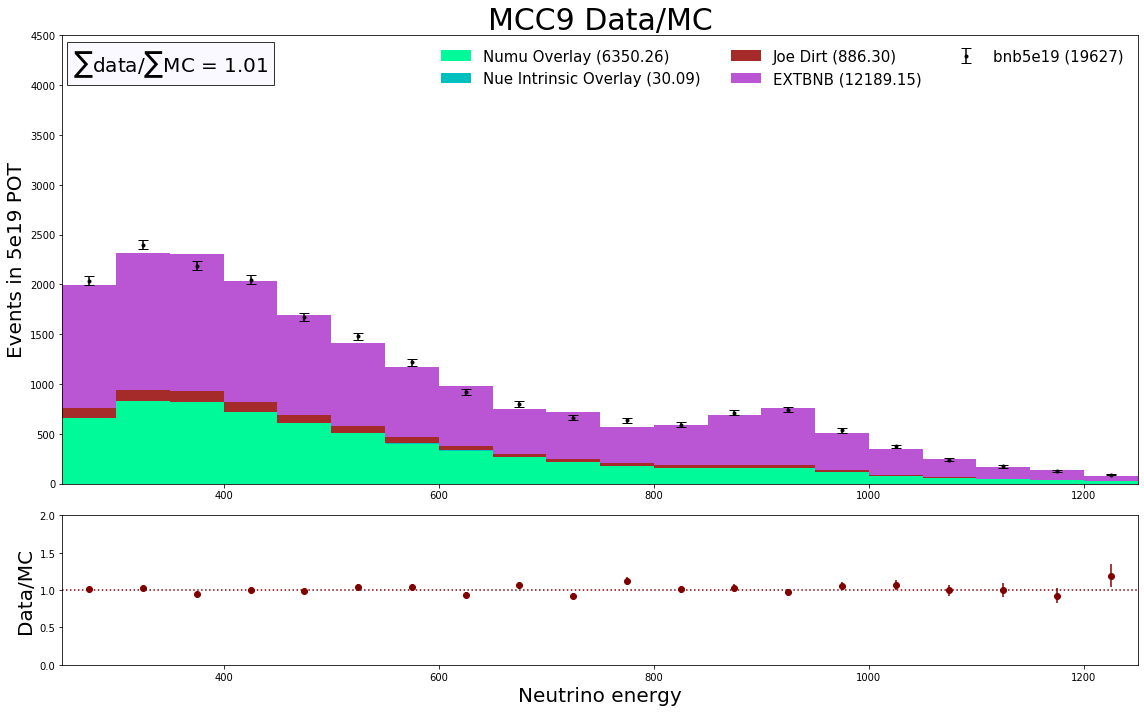

In [8]:
var_numu = df_numu_presel['Enu_1m1p'].values
var_nue = df_nue_presel['Enu_1m1p'].values
var_ext = df_ext_presel['Enu_1m1p'].values
var_data = df_data_presel['Enu_1m1p'].values
var_dirt = df_dirt_presel['Enu_1m1p'].values

fig,ax = plt.subplots(figsize=(16,10))
distplot_wratio(20,(250,1250),[var_numu,var_nue,var_dirt,var_ext],var_data,weights_data_presel,'Neutrino energy',4.5e3)
ax.annotate(r'Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.7,.7), xycoords='axes fraction',fontsize=15)
#ax.annotate('6808 Events in 5e19',xy=(.7,.6), xycoords='axes fraction',fontsize=20)


## This is where the magic happens

In [8]:
df_offvtx_numu_presel = df_numu_presel.query('scedir_corrected > 5')

df_CCQE_numu_presel = df_numu_presel.query('scedir_corrected <= 5 and interactionType==1001')
df_MEC_numu_presel = df_numu_presel.query('scedir_corrected <= 5 and interactionType==1000')

pizero = '(interactionType==1090 or interactionType==1086 or interactionType==1080 or interactionType==1015 or interactionType==1013 or interactionType==1011 or interactionType==1008 or interactionType==1006 or interactionType==1004)'
piplusminus= '(interactionType==1085 or interactionType==1079 or interactionType==1032 or interactionType==1017 or interactionType==1014 or interactionType==1007 or interactionType==1005 or interactionType==1003 or interactionType==1028 or interactionType==1021 or interactionType==1016 or interactionType==1012 or interactionType==1010 or interactionType==1009)'

df_pizero_numu_presel = df_numu_presel.query('scedir_corrected <= 5 and '+pizero)
df_piplusminus_numu_presel = df_numu_presel.query('scedir_corrected <= 5 and '+piplusminus)
df_other_numu_presel = df_numu_presel.query('scedir_corrected <= 5 and interactionType!=1001 and interactionType!=1000 and not '+pizero+' and not '+piplusminus)

weights_offvtxnumu_presel = df_offvtx_numu_presel['geniereweight']*NUMU_SCALE
weights_CCQEnumu_presel = df_CCQE_numu_presel['geniereweight']*NUMU_SCALE
weights_MECnumu_presel = np.ones(len(df_MEC_numu_presel))*NUMU_SCALE
weights_PIZEROnumu_presel = np.ones(len(df_pizero_numu_presel))*NUMU_SCALE
weights_PIPLUSMINUSnumu_presel = np.ones(len(df_piplusminus_numu_presel))*NUMU_SCALE
weights_OTHERnumu_presel = np.ones(len(df_other_numu_presel))*NUMU_SCALE
weights_nue_presel = df_nue_presel['geniereweight']*NUE_SCALE
weights_ext_presel = np.ones(len(df_ext_presel))*EXT_SCALE
weights_data_presel = np.ones(len(df_data_presel))*DATA_SCALE
weights_dirt_presel = np.ones(len(df_dirt_presel))*DIRT_SCALE


a_weights = [weights_CCQEnumu_presel,weights_MECnumu_presel,weights_PIZEROnumu_presel,weights_PIPLUSMINUSnumu_presel,weights_OTHERnumu_presel,weights_offvtxnumu_presel,weights_nue_presel,weights_dirt_presel,weights_ext_presel]
a_scale = [NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUE_SCALE,DIRT_SCALE,EXT_SCALE]

a_labels = [r'$\nu_\mu$ CCQE',r'$\nu_\mu$ MEC',r'$\nu_\mu$ Res $\pi^0$',r'$\nu_\mu$ Res $\pi^{+/-}$',r'$\nu_\mu$ Other','Off Vertex',r'$\nu_e$ Intrinsic Overlay','Dirt','EXTBNB']
a_colors = ['blue','cyan','darkgreen','greenyellow','gold','grey','pink','peru','fuchsia']

Events: 21103.0
MC:  20899.04049600124


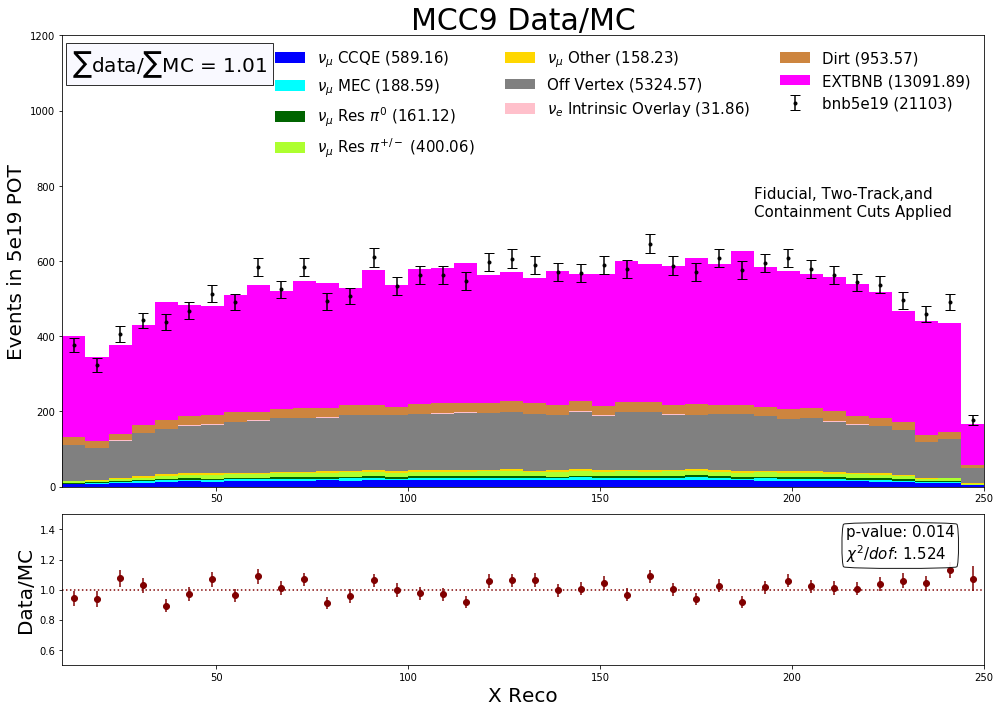

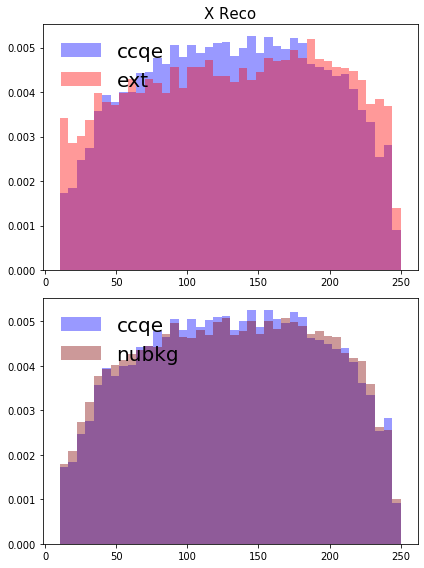

In [9]:
vartest = 'Xreco'
varname = 'X Reco'
myrange = (10,250)
nbins = 40
yscale = 1.2e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 21042.0
MC:  20842.438126564666


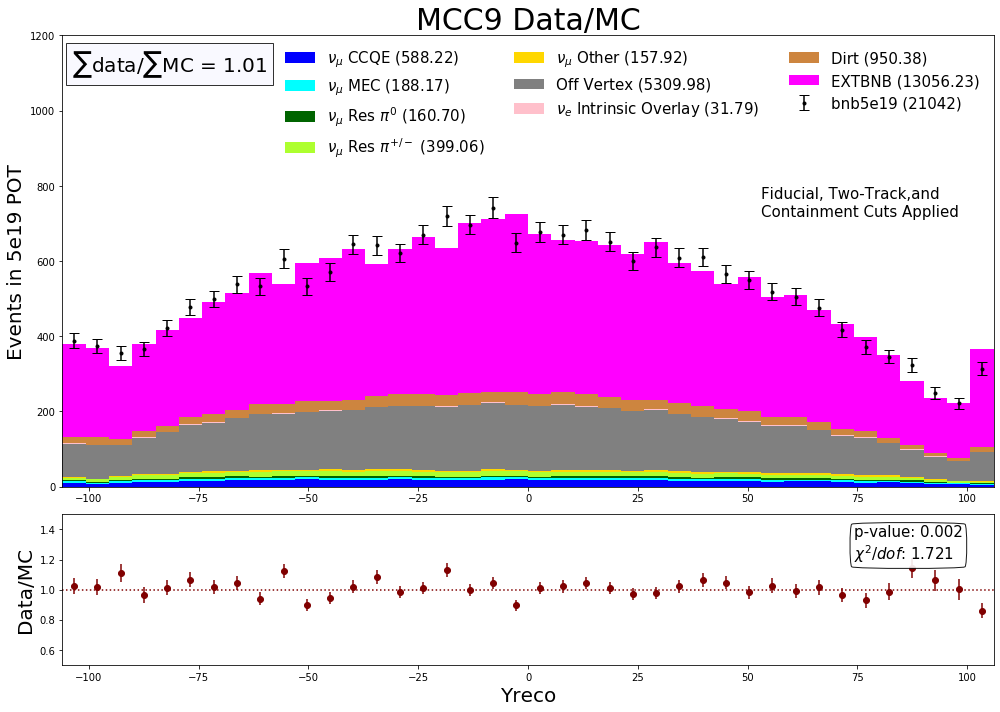

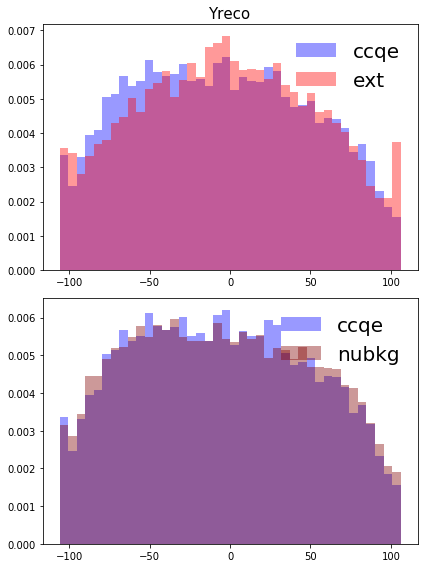

In [19]:
vartest = 'Yreco'
varname = 'Yreco'
myrange = (-106,106)
nbins = 40
yscale = 1.2e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 21030.0
MC:  20830.458227305833


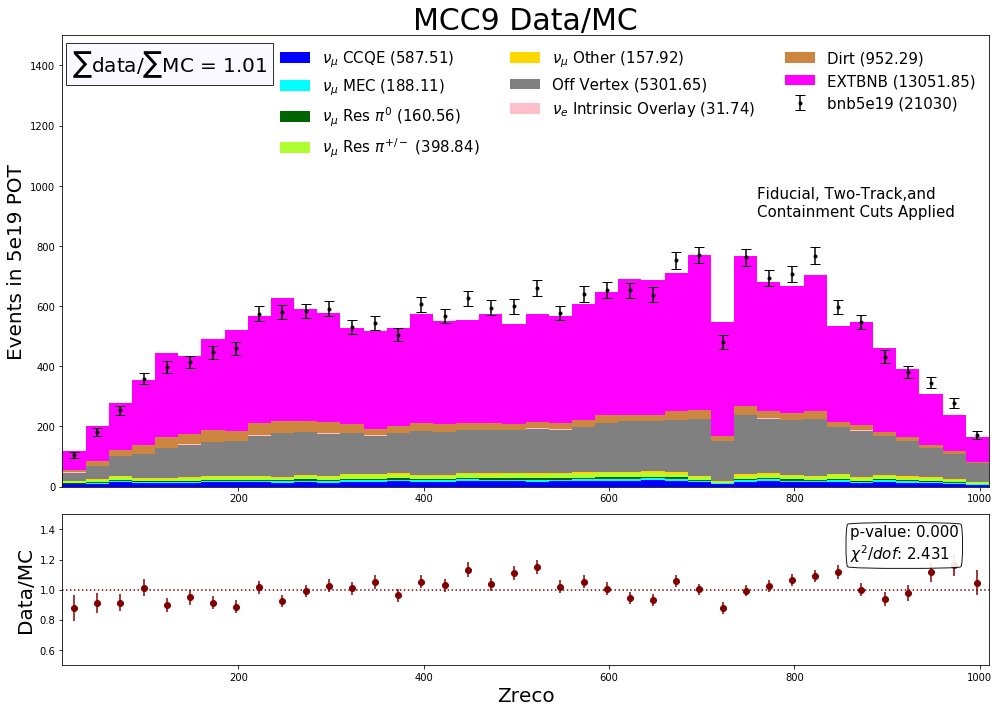

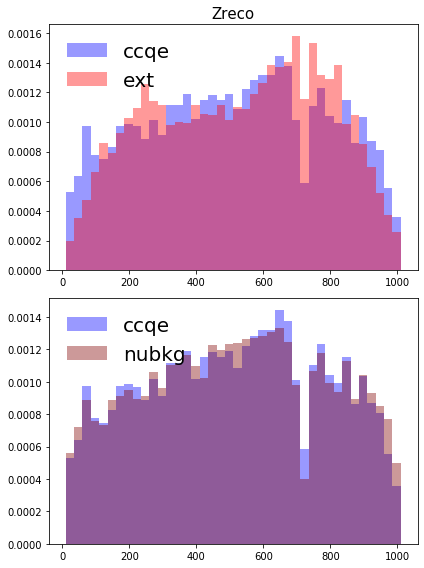

In [20]:
vartest = 'Zreco'
varname = 'Zreco'
myrange = (10,1010)
nbins = 40
yscale = 1.5e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 20338.0
MC:  20132.016619730995


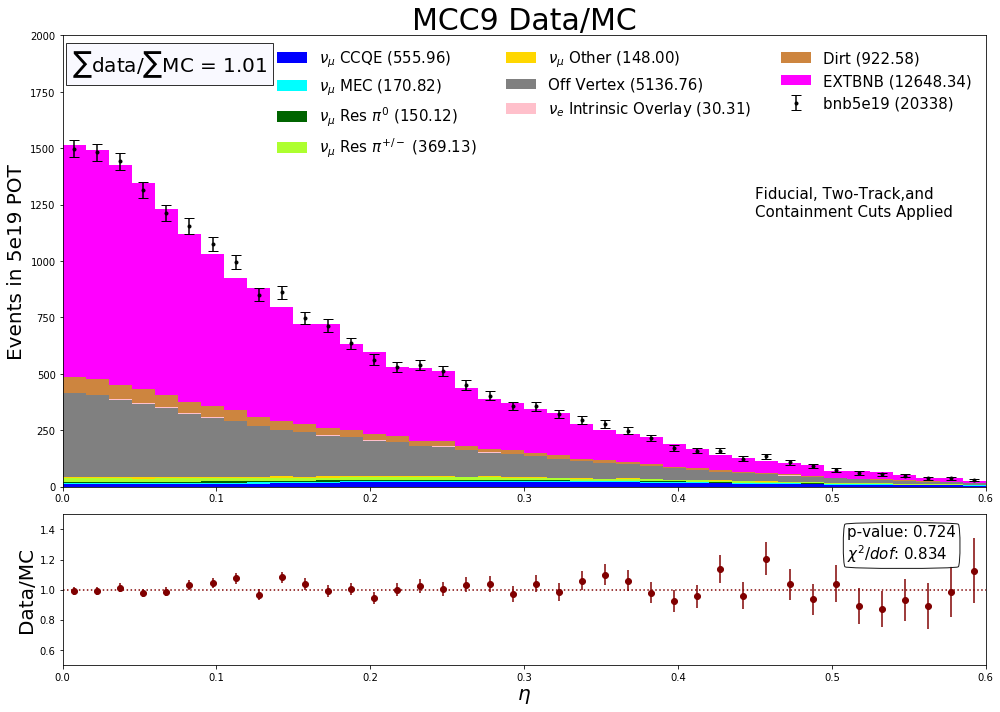

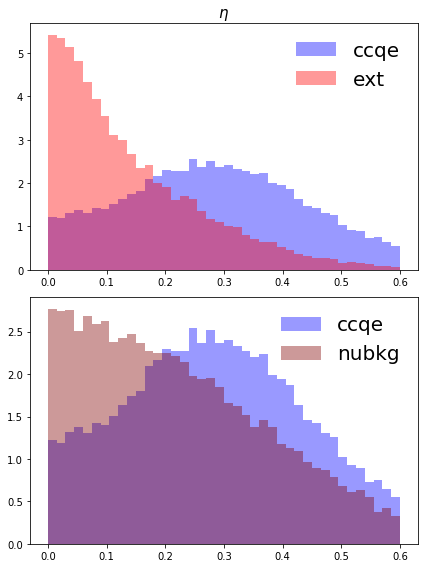

In [25]:
vartest = 'Eta'
varname = r'$\eta$'
myrange = (0,.6)
nbins = 40
yscale = 2e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 20246.0
MC:  20059.049579377628


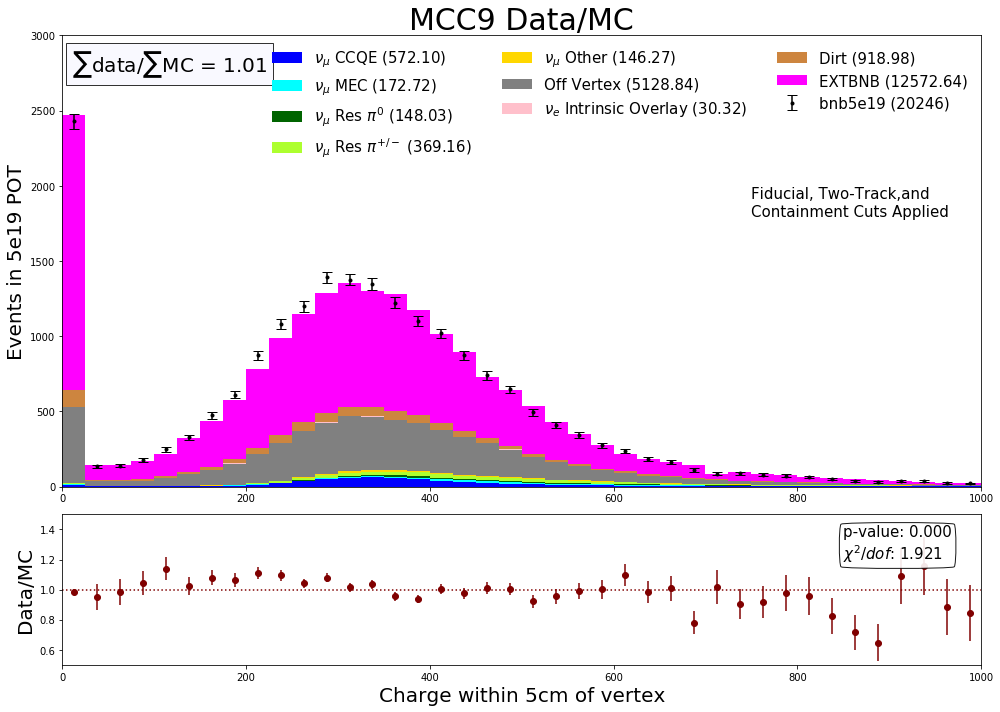

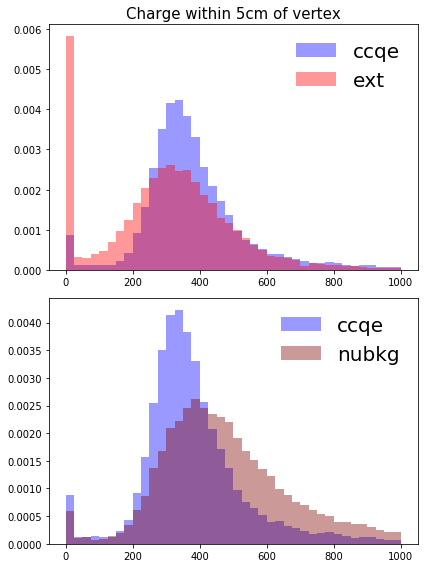

In [26]:
vartest = 'ChargeNearTrunk'
varname = 'Charge within 5cm of vertex'
myrange = (0,1000)
nbins = 40
yscale = 3e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 20174.0
MC:  20047.067596850982


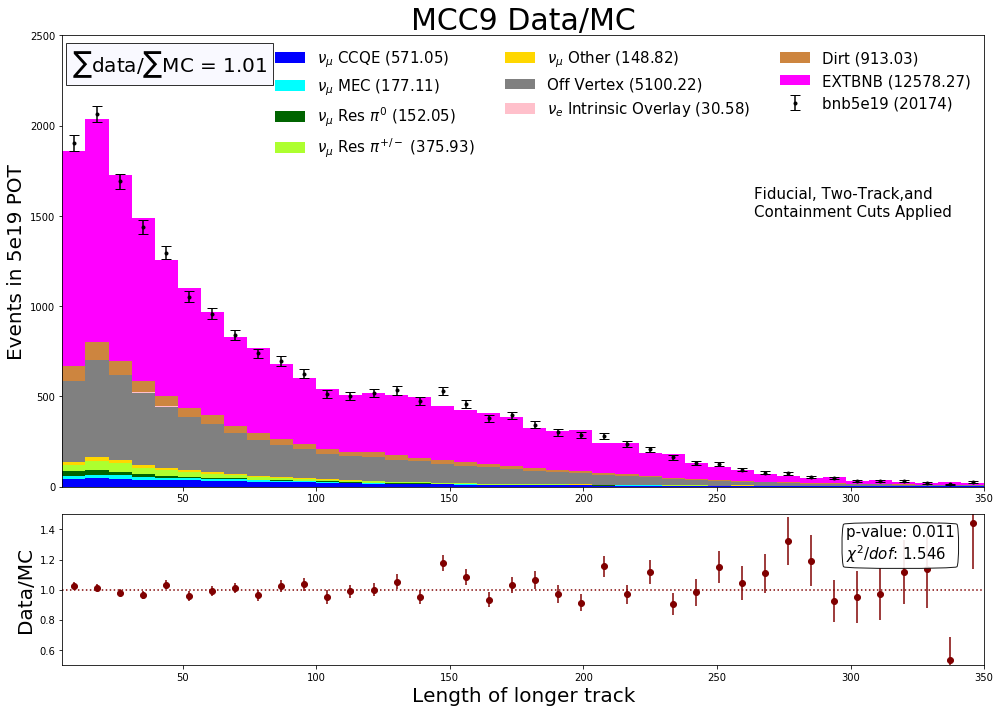

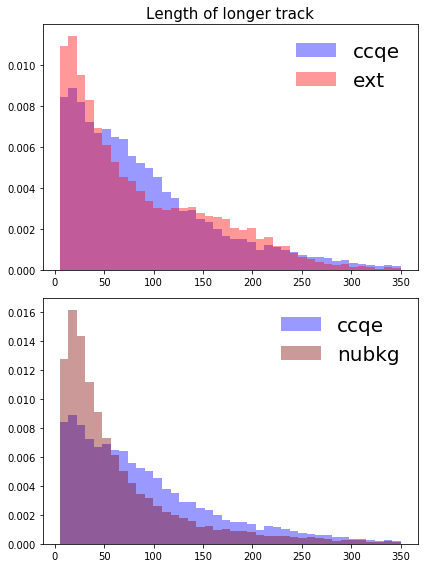

In [32]:
vartest = 'LongTrackLen'
varname = 'Length of longer track'
myrange = (5,350)
nbins = 40
yscale = 2.5e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 17474.0
MC:  17291.33161710675


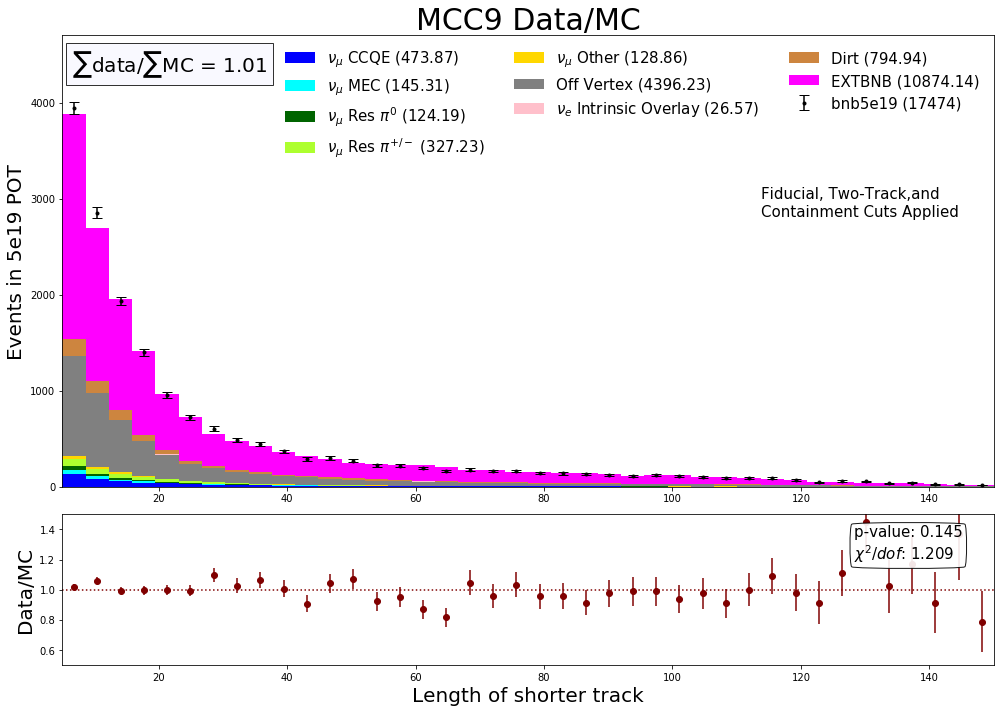

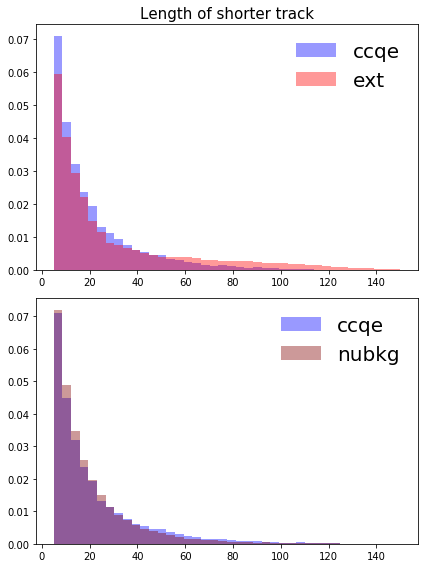

In [34]:
vartest = 'ShortTrackLen'
varname = 'Length of shorter track'
myrange = (5,150)
nbins = 40
yscale = 4.7e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 13621.0
MC:  13469.036562030493


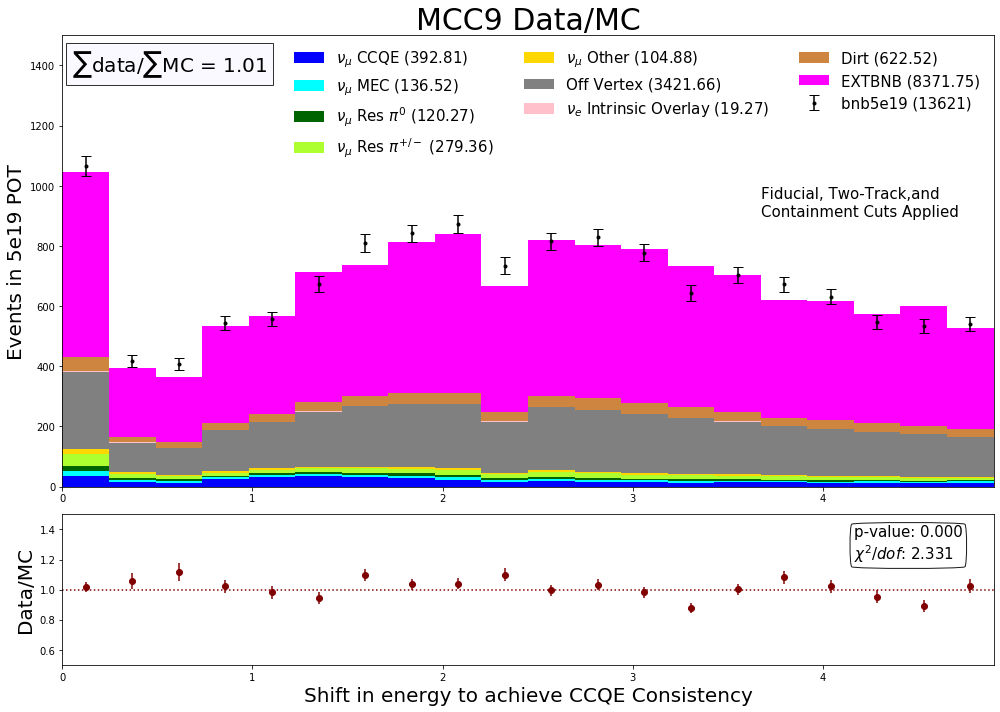

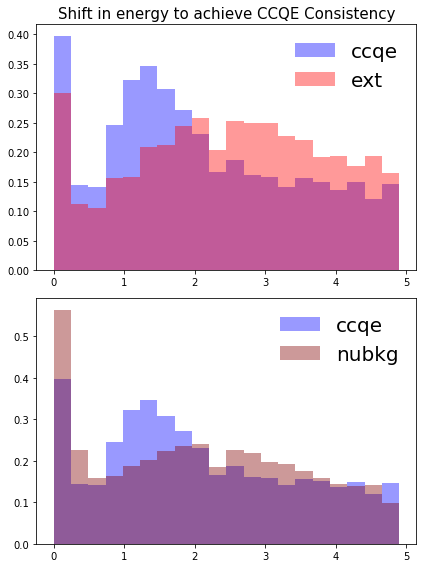

In [35]:
vartest = 'CCQEEnergyShift_1m1p'
varname = 'Shift in energy to achieve CCQE Consistency'
myrange = (0,4.9)
nbins = 20
yscale = 1.5e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 19627.0
MC:  19455.792358874896


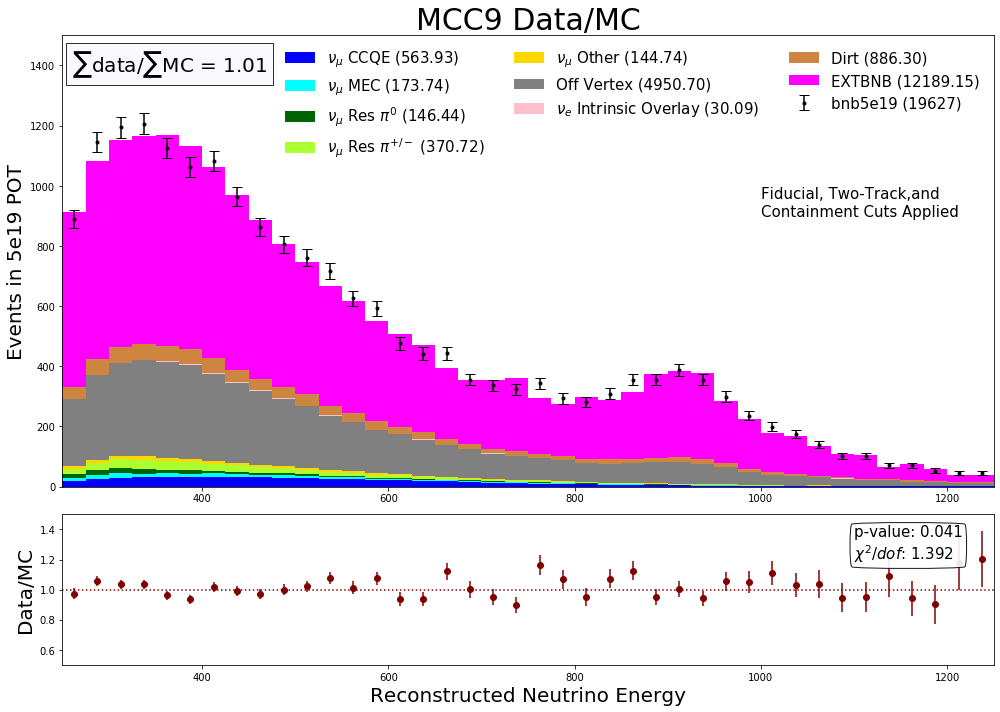

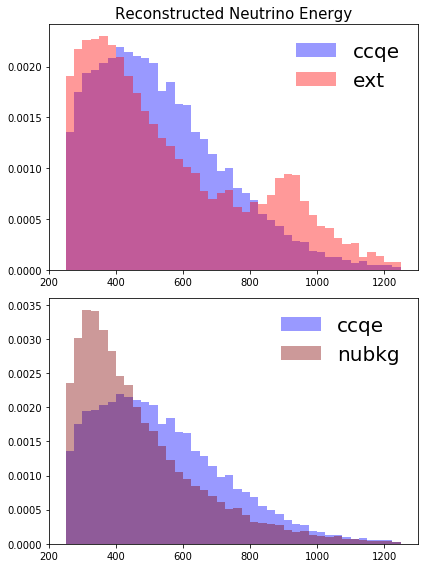

In [36]:
vartest = 'Enu_1m1p'
varname = 'Reconstructed Neutrino Energy'
myrange = (250,1250)
nbins = 40
yscale = 1.5e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 20503.0
MC:  20327.60323681629


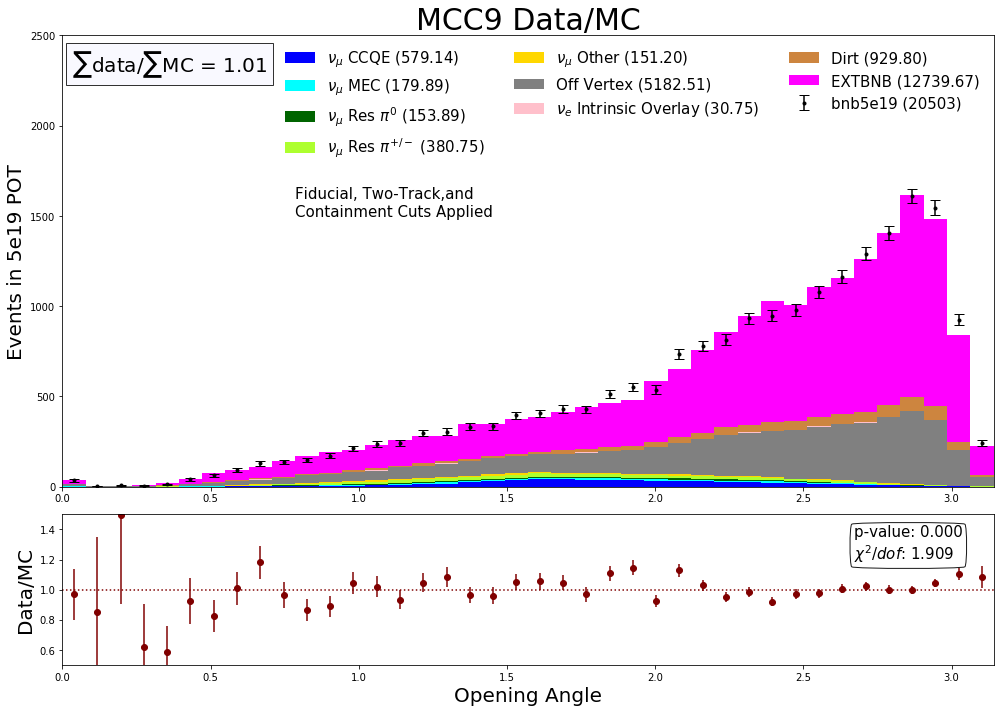

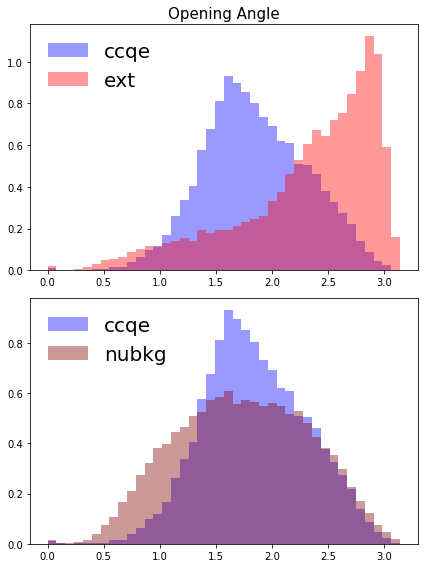

In [41]:
vartest = 'OpenAng'
varname = 'Opening Angle'
myrange = (0,np.pi)
nbins = 40
yscale = 2.5e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.25,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 20503.0
MC:  20329.002380235797


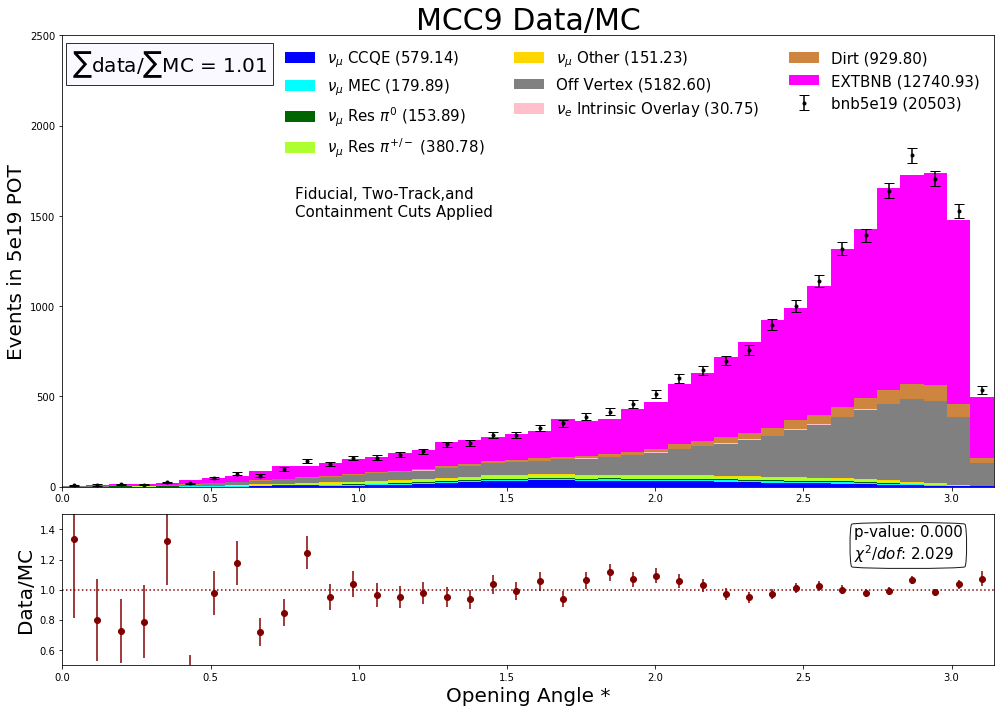

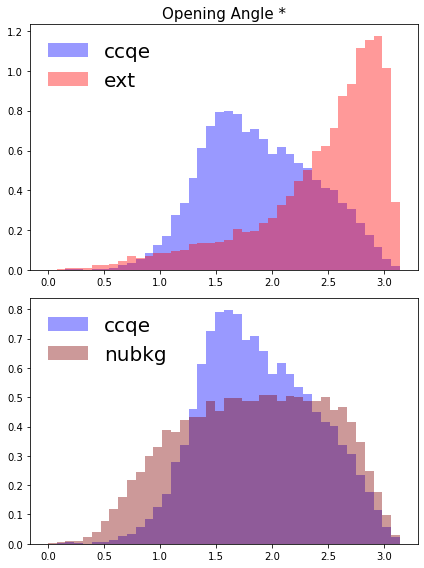

In [42]:
vartest = 'OpenAngB_1m1p'
varname = 'Opening Angle *'
myrange = (0,np.pi)
nbins = 40
yscale = 2.5e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.25,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 20494.0
MC:  20325.504436493262


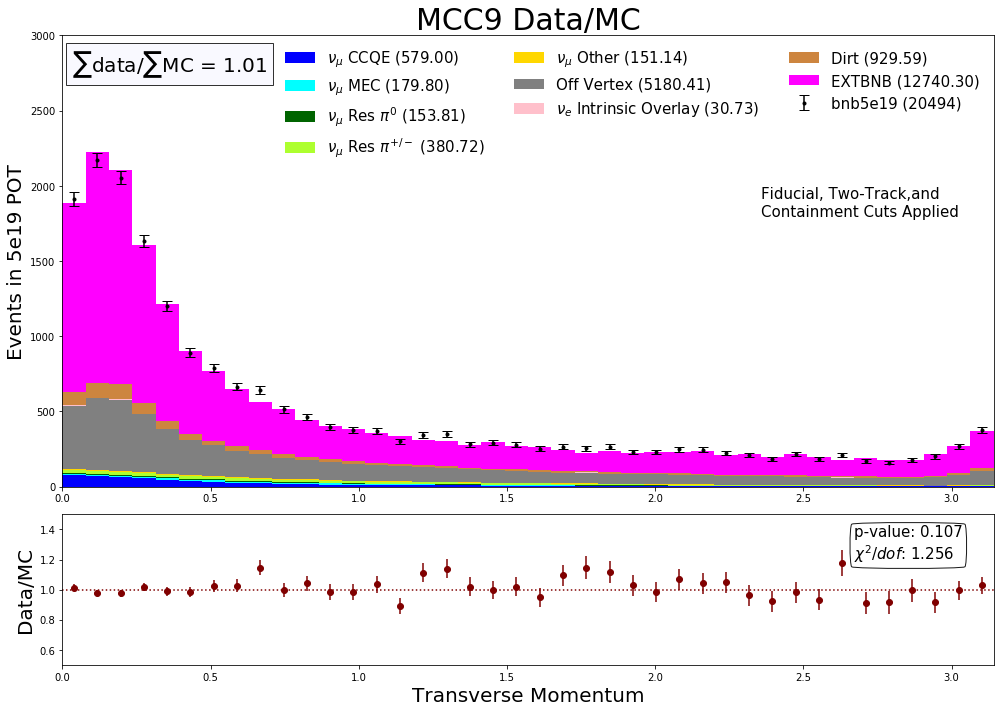

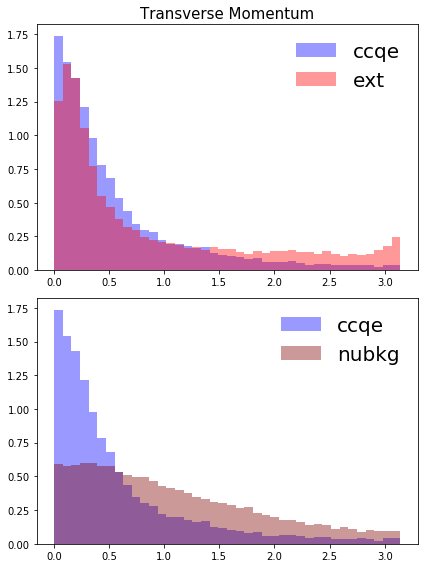

In [43]:
vartest = 'PhiT_1m1p'
varname = 'Transverse Momentum'
myrange = (0,np.pi)
nbins = 40
yscale = 3e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 20498.0
MC:  20322.56641900588


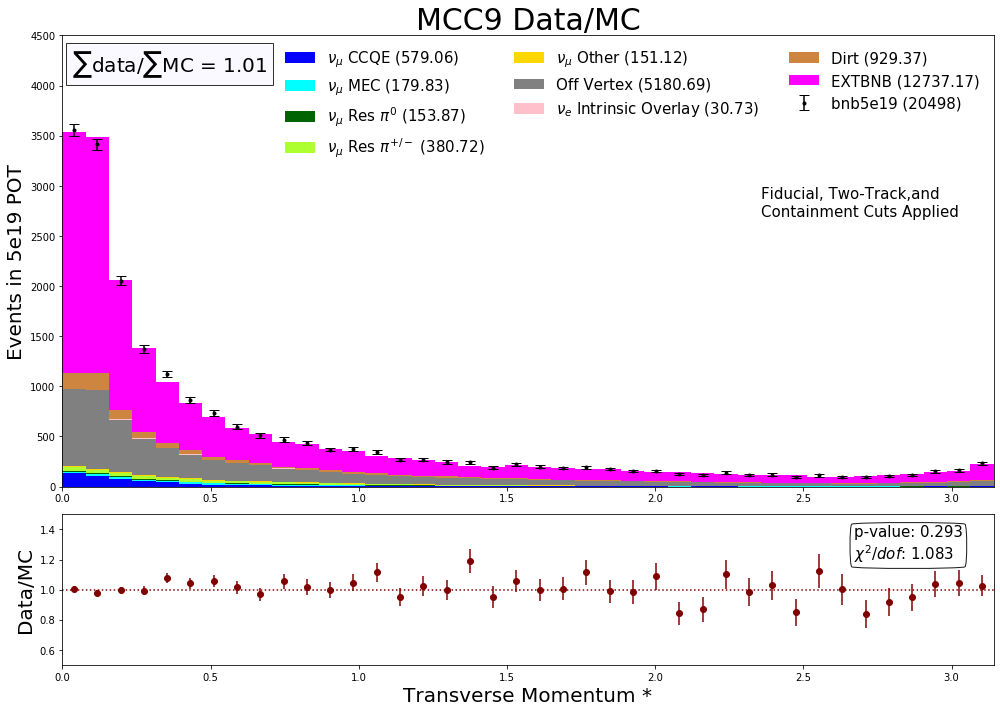

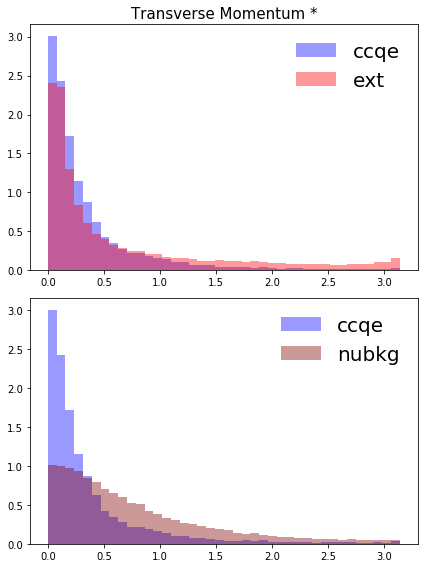

In [44]:
vartest = 'PhiTB_1m1p'
varname = 'Transverse Momentum *'
myrange = (0,np.pi)
nbins = 40
yscale = 4.5e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 20499.0
MC:  20323.2843941423


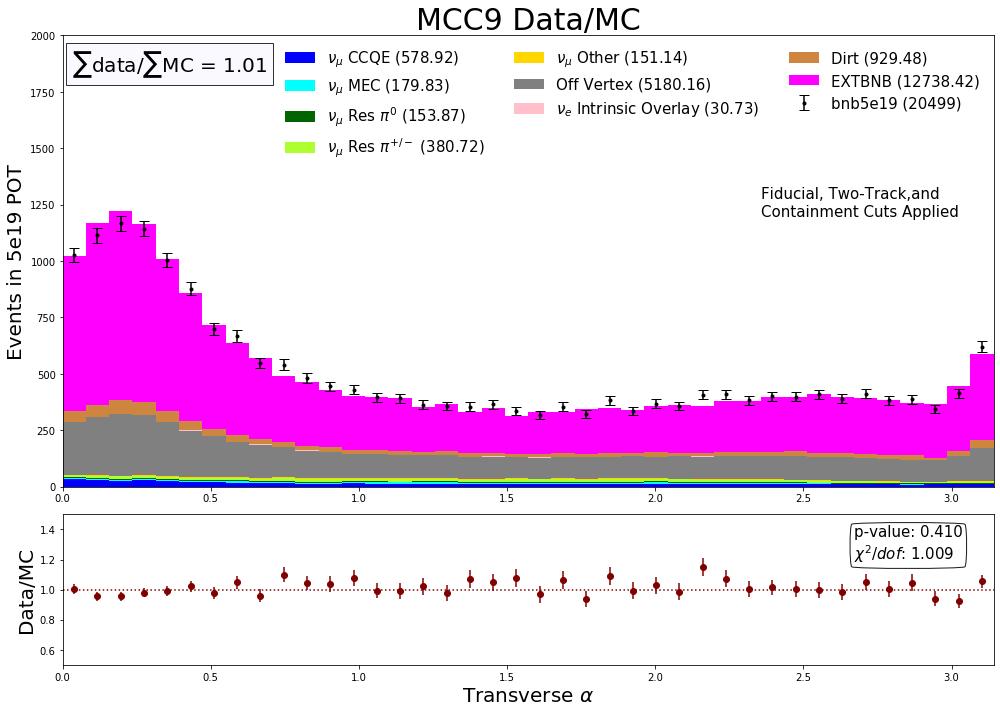

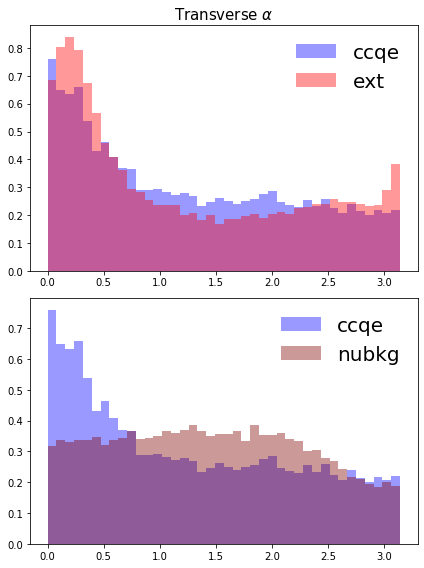

In [49]:
vartest = 'AlphaT_1m1p'
varname = r'Transverse $\alpha$'
myrange = (0,np.pi)
nbins = 40
yscale = 2e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 20495.0
MC:  20323.3221644181


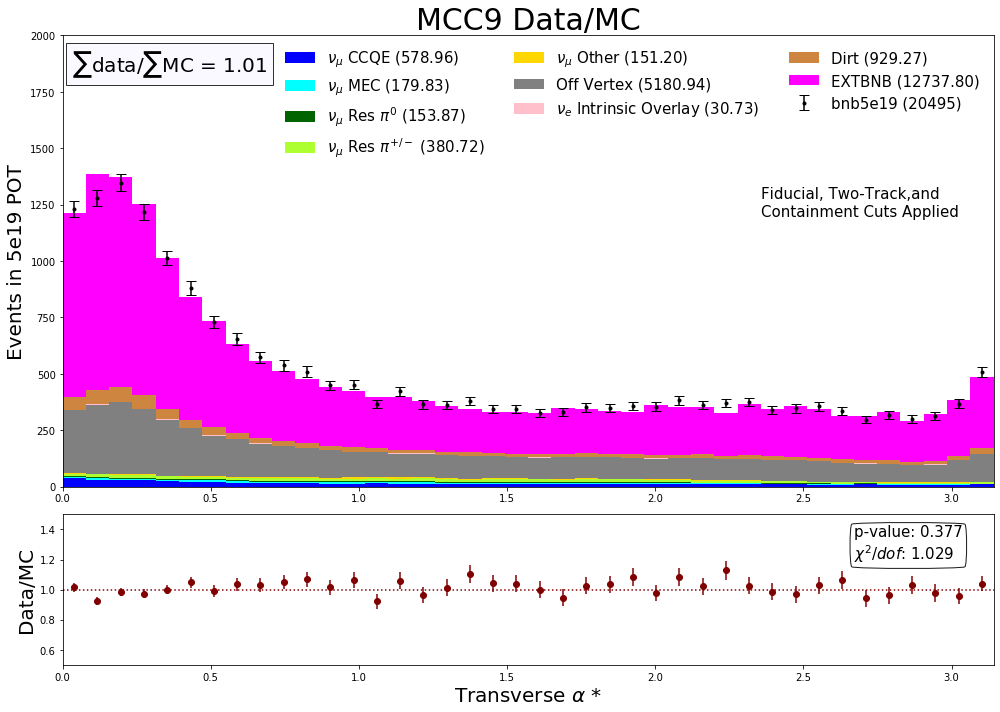

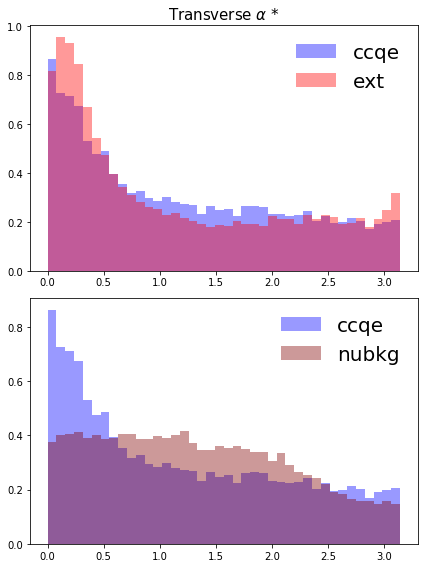

In [48]:
vartest = 'AlphaTB_1m1p'
varname = r'Transverse $\alpha$ *'
myrange = (0,np.pi)
nbins = 40
yscale = 2e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 19905.0
MC:  19786.29901135509


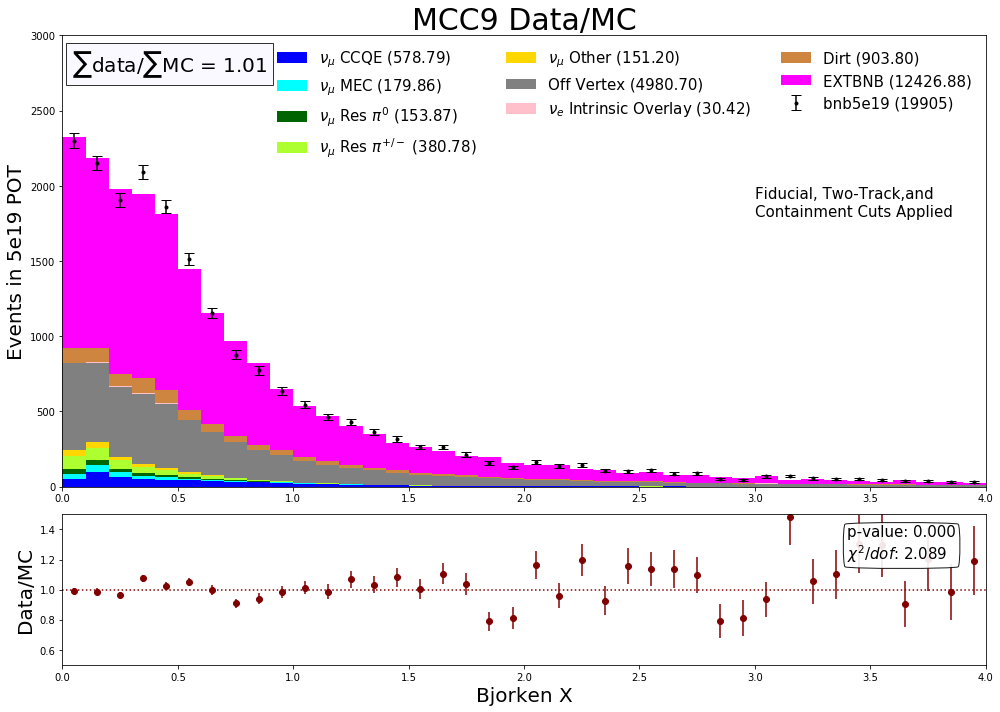

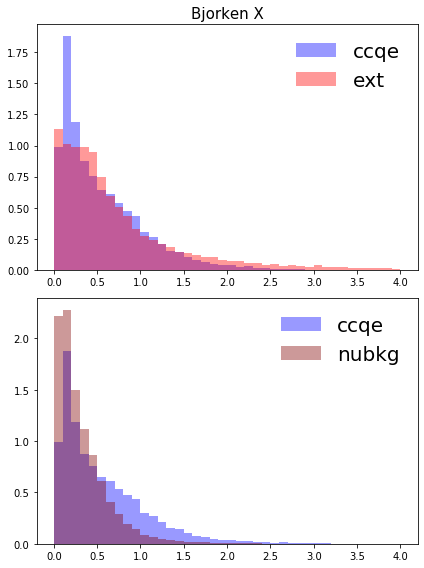

In [53]:
vartest = 'BjX_1m1p'
varname = 'Bjorken X'
myrange = (0,4)
nbins = 40
yscale = 3e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 19832.0
MC:  19740.50587220673


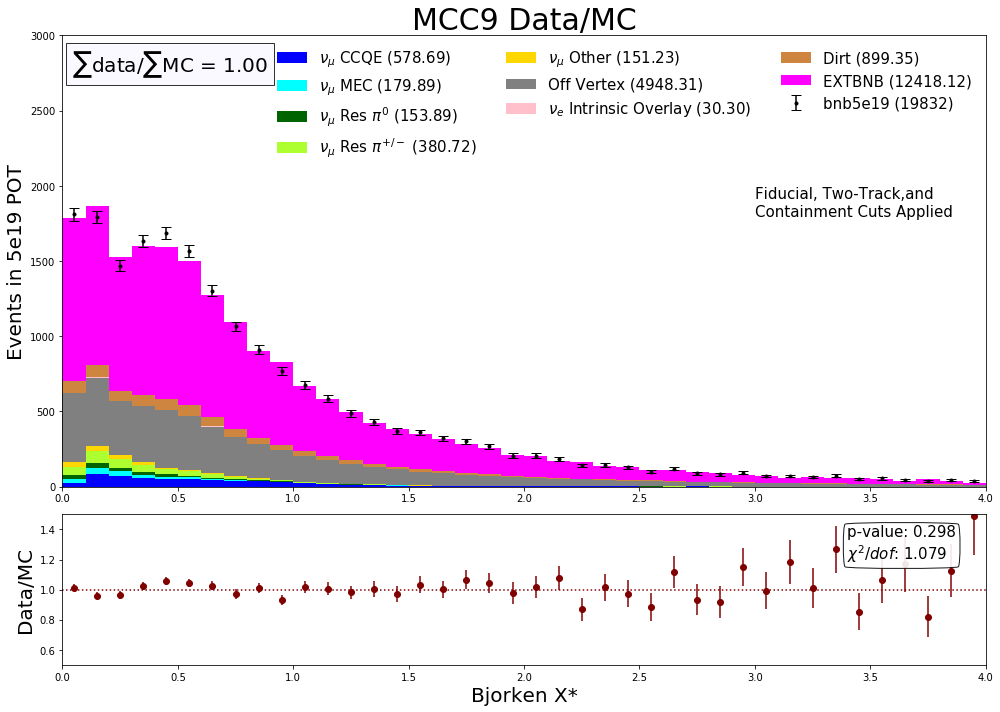

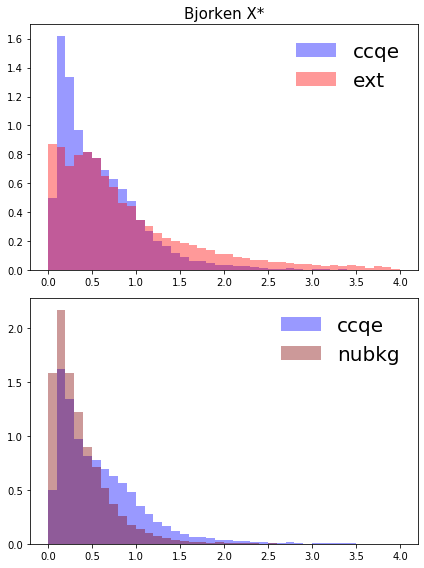

In [54]:
vartest = 'BjXB_1m1p'
varname = 'Bjorken X*'
myrange = (0,4)
nbins = 40
yscale = 3e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 20482.0
MC:  20310.45228643332


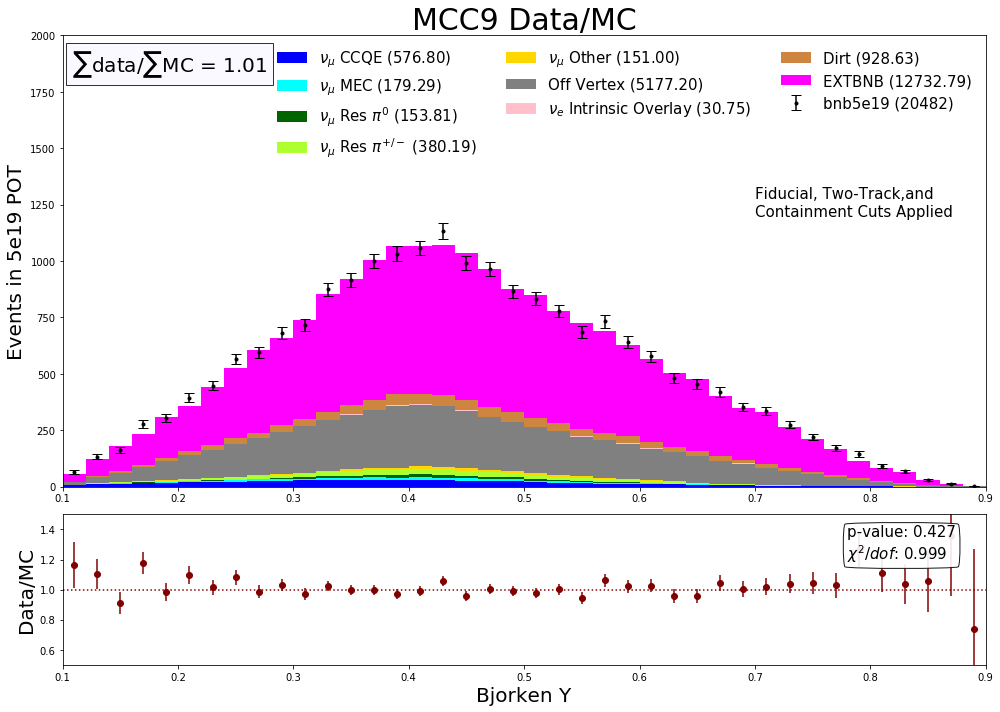

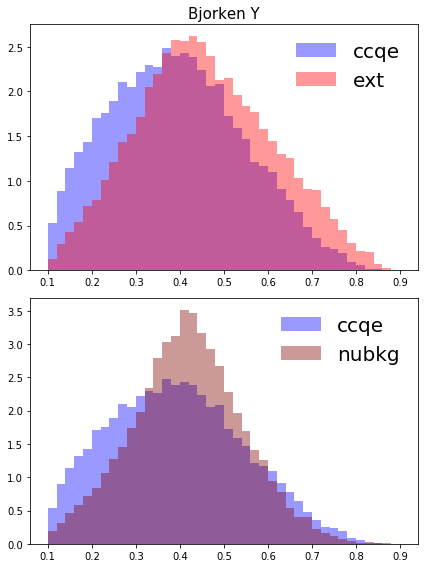

In [55]:
vartest = 'BjY_1m1p'
varname = 'Bjorken Y'
myrange = (0.1,.9)
nbins = 40
yscale = 2e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide


Events: 20439.0
MC:  20277.30350156696


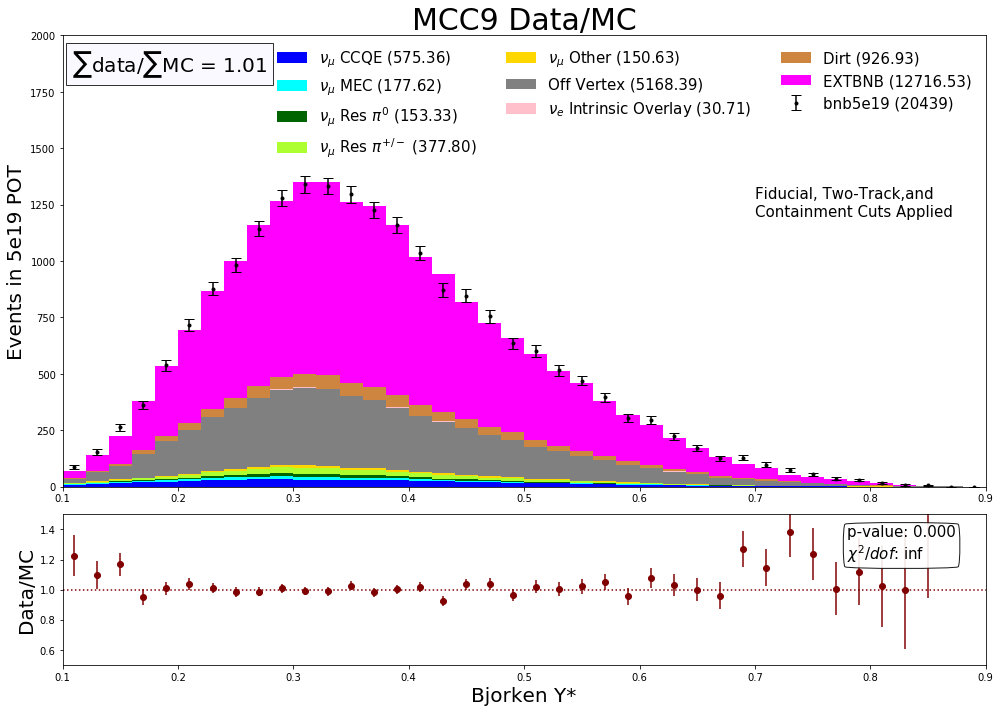

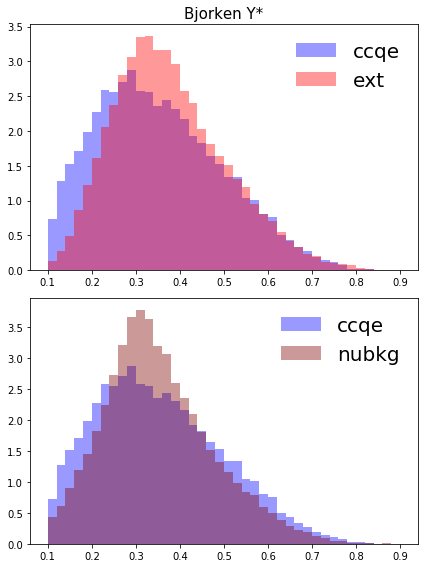

In [56]:
vartest = 'BjYB_1m1p'
varname = 'Bjorken Y*'
myrange = (0.1,.9)
nbins = 40
yscale = 2e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 18836.0
MC:  18755.680200430572


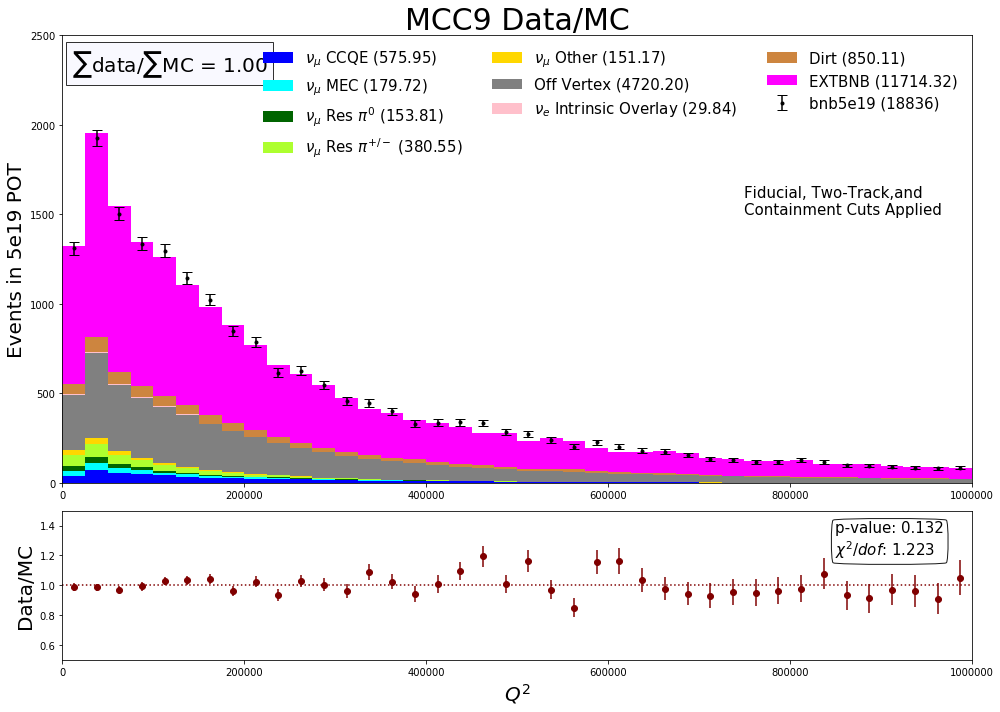

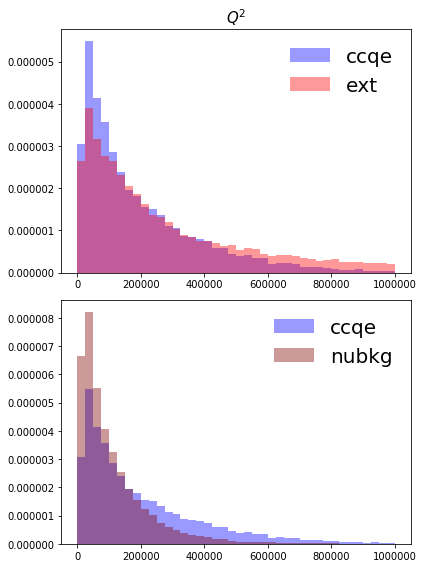

In [60]:
vartest = 'Q2_1m1p'
varname = r'$Q^2$'
myrange = (0,1000000)
nbins = 40
yscale = 2.5e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 19022.0
MC:  18958.674436969588


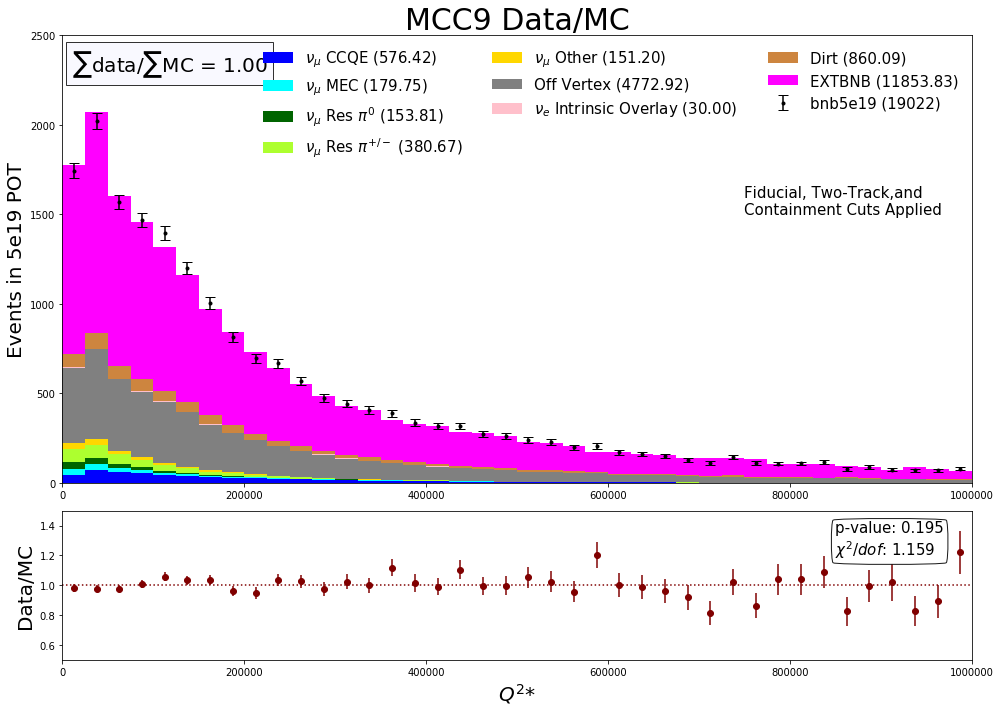

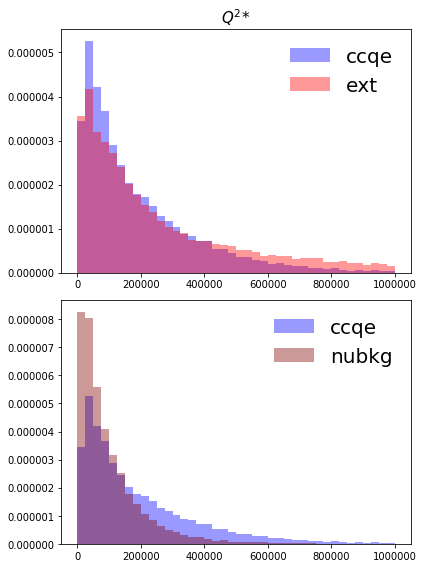

In [61]:
vartest = 'Q2B_1m1p'
varname = r'$Q^2$*'
myrange = (0,1000000)
nbins = 40
yscale = 2.5e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 19087.0
MC:  18951.067487389162


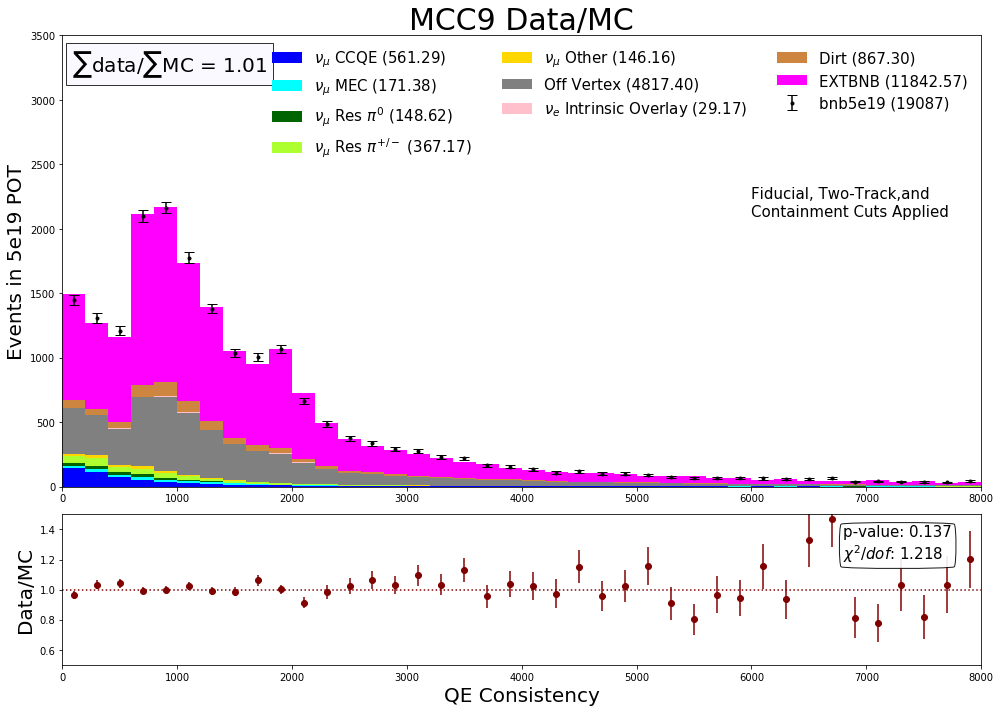

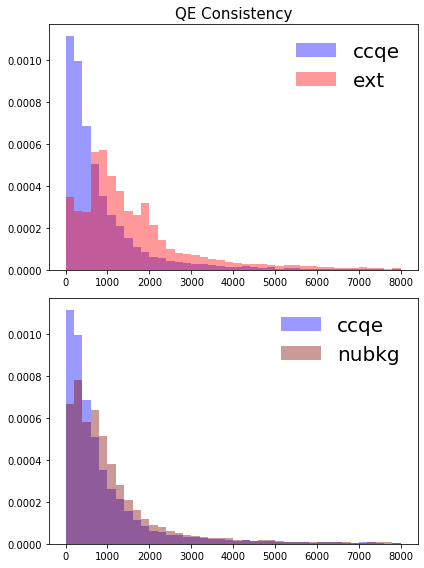

In [62]:
vartest = 'Sph_1m1p'
varname = 'QE Consistency'
myrange = (0,8000)
nbins = 40
yscale = 3.5e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 19253.0
MC:  19130.064728032303


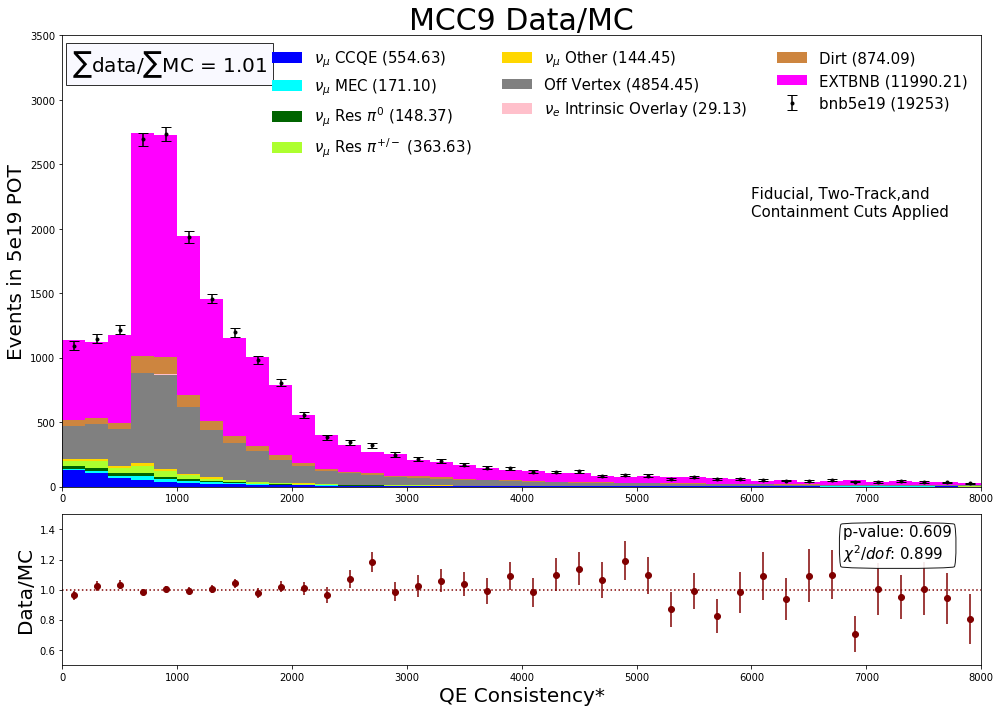

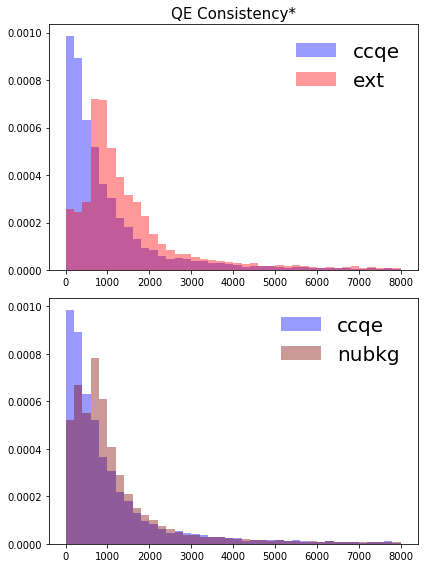

In [63]:
vartest = 'SphB_1m1p'
varname = 'QE Consistency*'
myrange = (0,8000)
nbins = 40
yscale = 3.5e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 20385.0
MC:  20205.780264782807


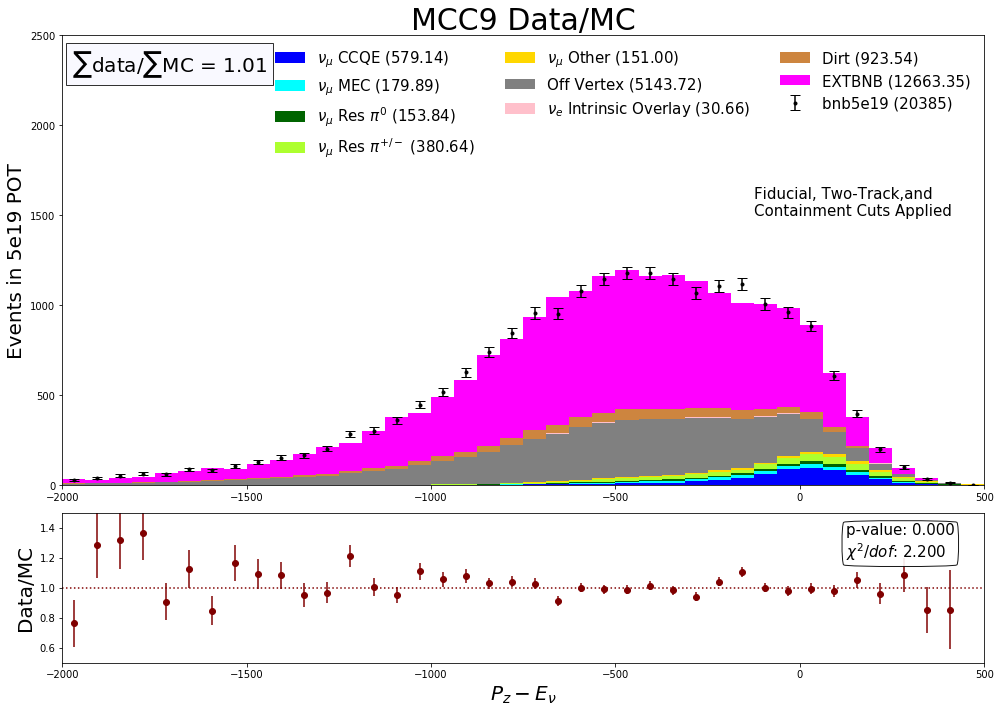

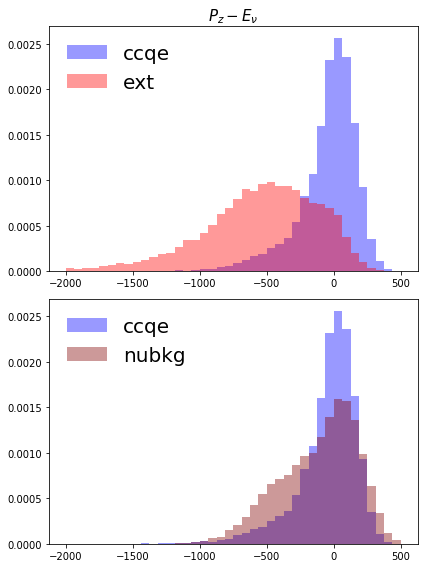

In [64]:
vartest = 'PzEnu_1m1p'
varname = r'$P_z - E_\nu$'
myrange = (-2000,500)
nbins = 40
yscale = 2.5e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 18442.0
MC:  18268.76855770075


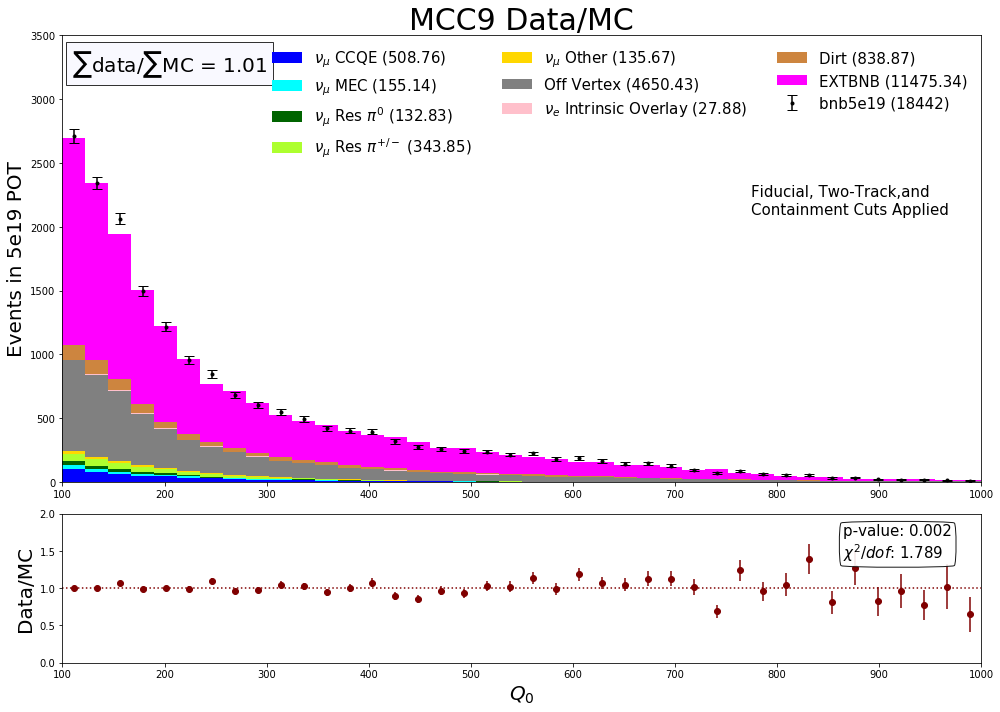

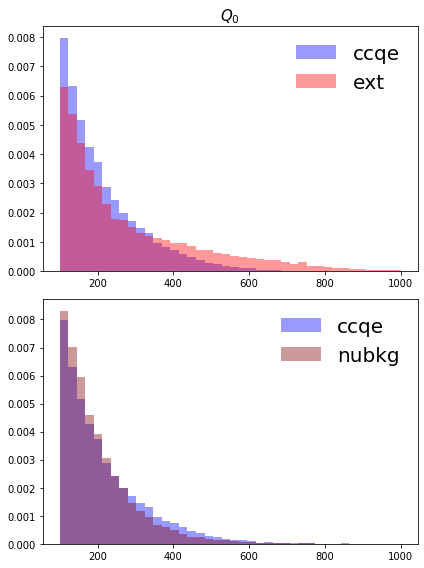

In [114]:
vartest = 'Q0_1m1p'
varname = r'$Q_0$'
myrange = (100,1000)
nbins = 40
yscale = 3.5e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 19871.0
MC:  19734.727287670063


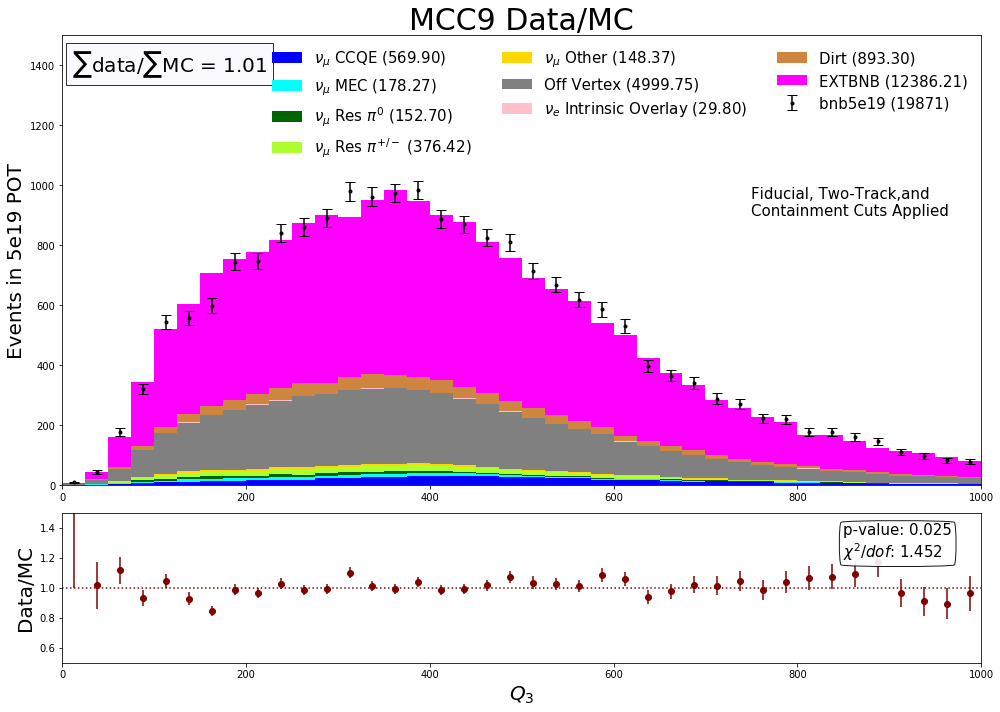

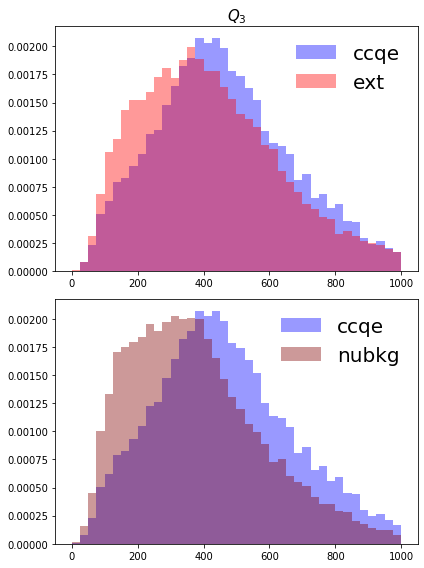

In [65]:
vartest = 'Q3_1m1p'
varname = r'$Q_3$'
myrange = (0,1000)
nbins = 40
yscale = 1.5e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 20502.0
MC:  20327.7515850715


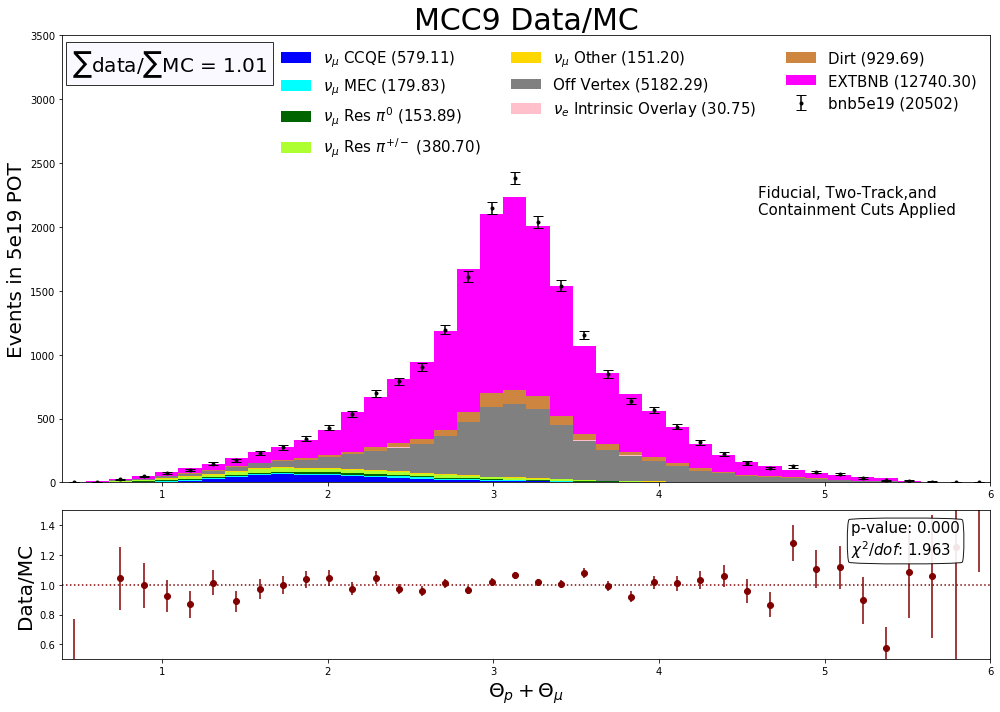

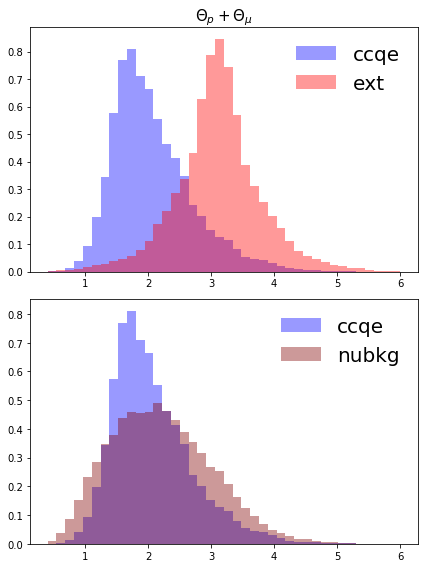

In [66]:
vartest = 'Thetas'
varname = r'$\Theta_p + \Theta_\mu$'
myrange = (.4,6)
nbins = 40
yscale = 3.5e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 20497.0
MC:  20323.7657606513


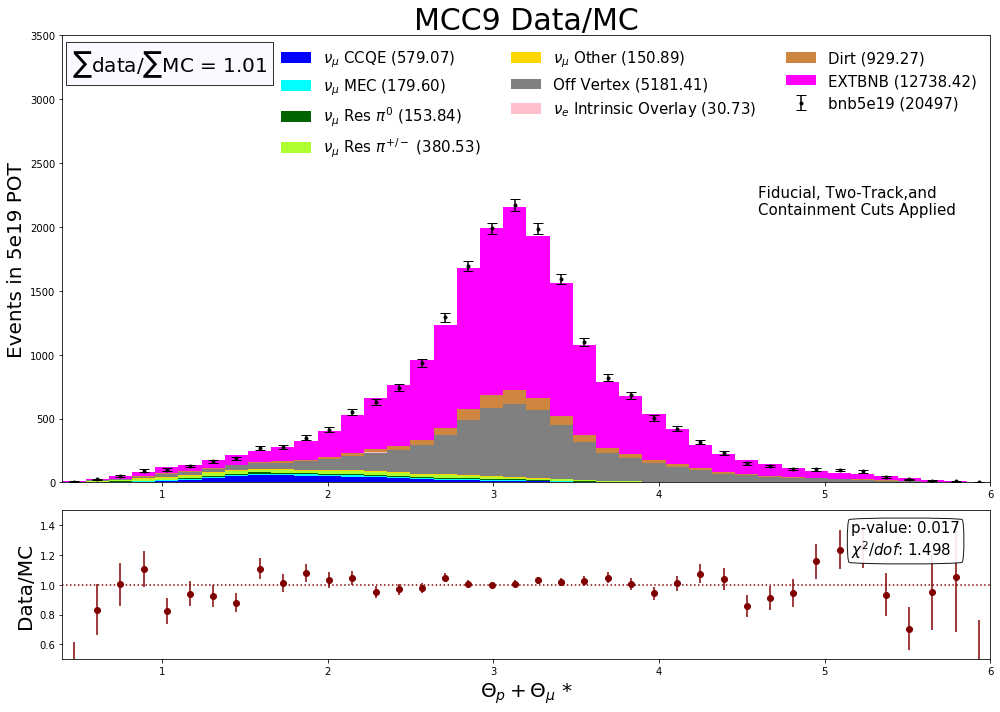

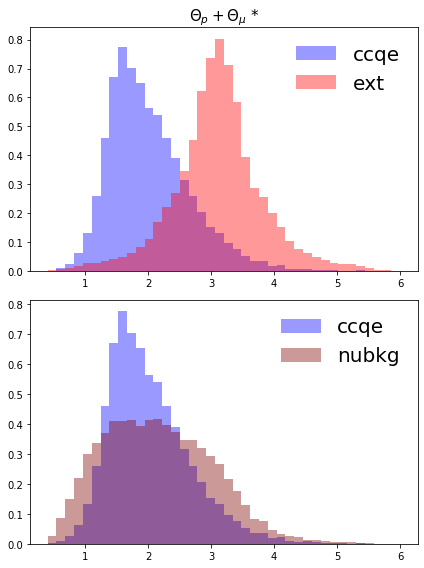

In [67]:
vartest = 'ThetasB_1m1p'
varname = r'$\Theta_p + \Theta_\mu$ *'
myrange = (.4,6)
nbins = 40
yscale = 3.5e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 20472.0
MC:  20300.784168547536


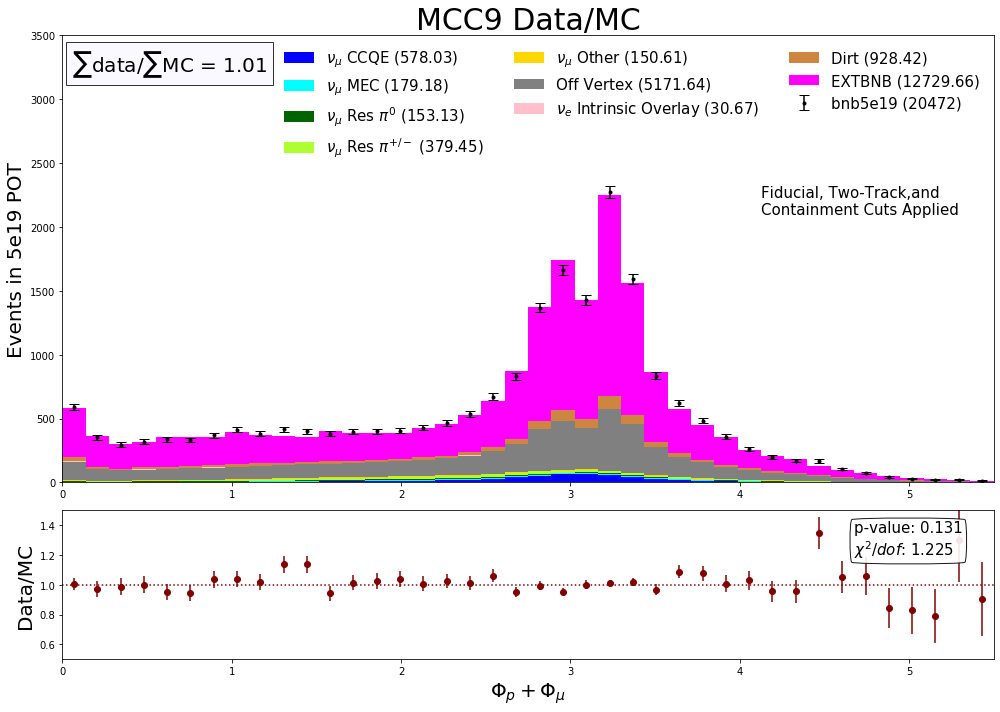

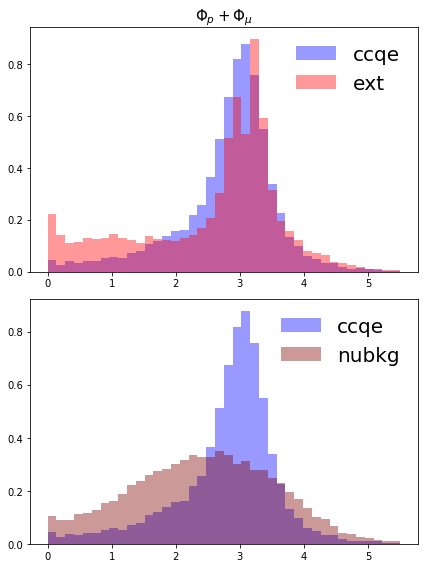

In [71]:
vartest = 'Phis'
varname = r'$\Phi_p + \Phi_\mu$'
myrange = (0,5.5)
nbins = 40
yscale = 3.5e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 20483.0
MC:  20316.53642451347


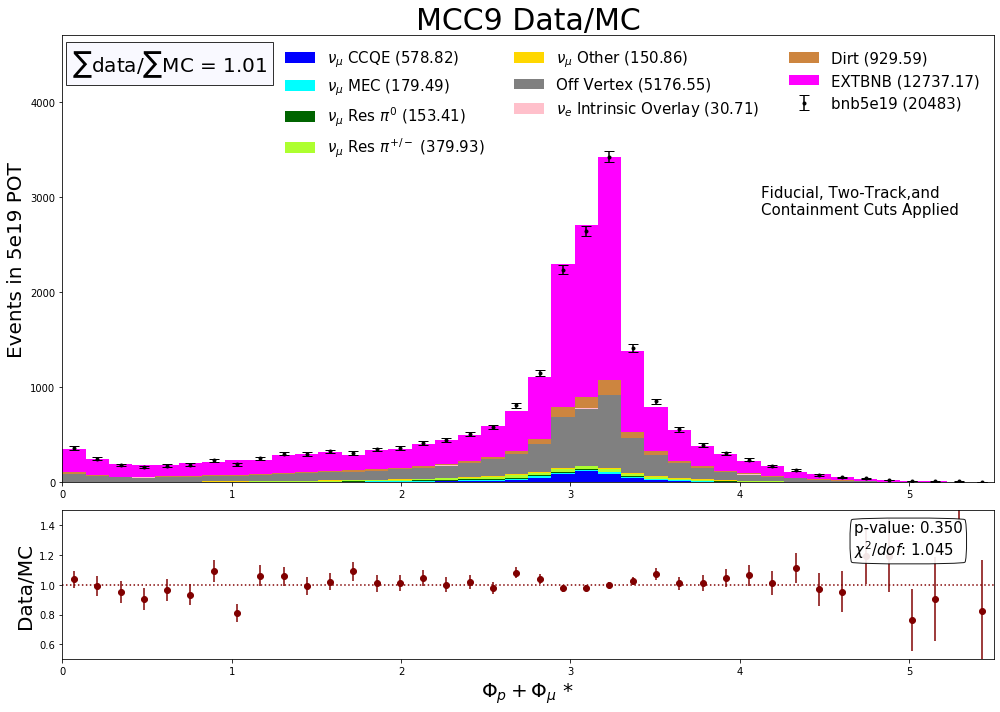

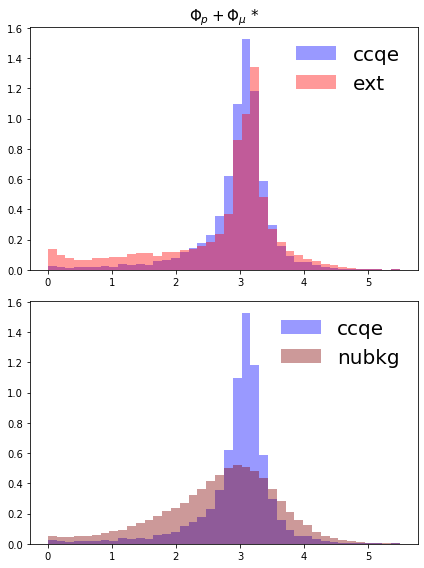

In [72]:
vartest = 'PhisB_1m1p'
varname = r'$\Phi_p + \Phi_\mu$ *'
myrange = (0,5.5)
nbins = 40
yscale = 4.7e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 20503.0
MC:  20329.002380235812


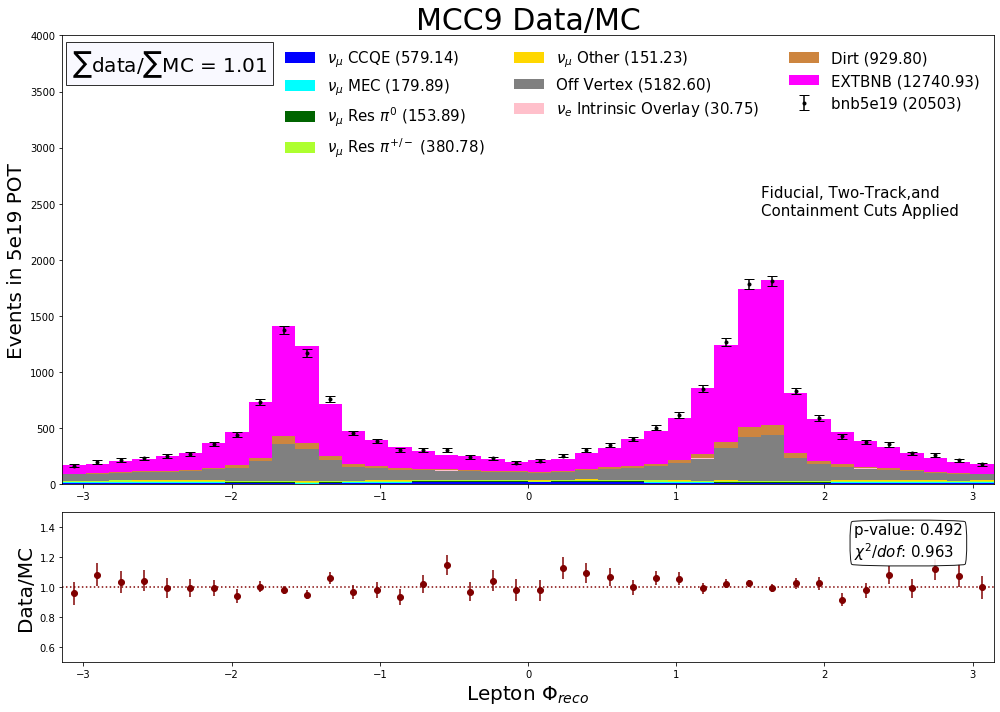

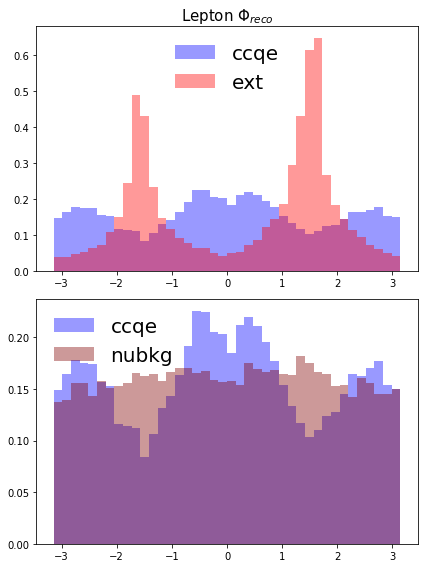

In [73]:
vartest = 'Lepton_PhiReco'
varname = r'Lepton $\Phi_{reco}$'
myrange = (-np.pi,np.pi)
nbins = 40
yscale = 4e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 20503.0
MC:  20329.002380235754


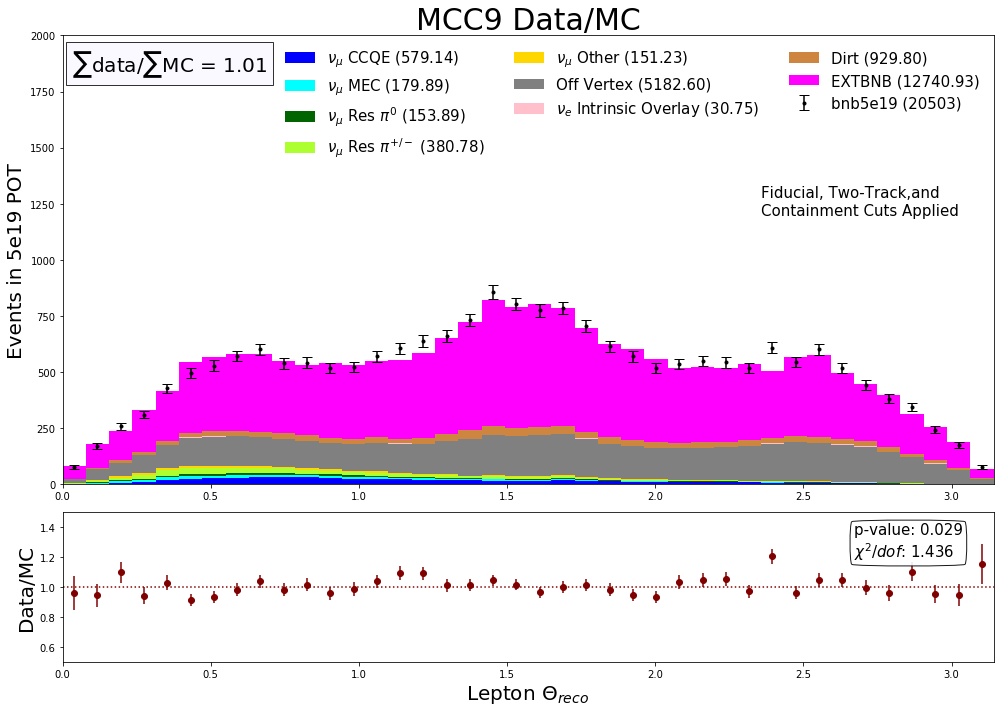

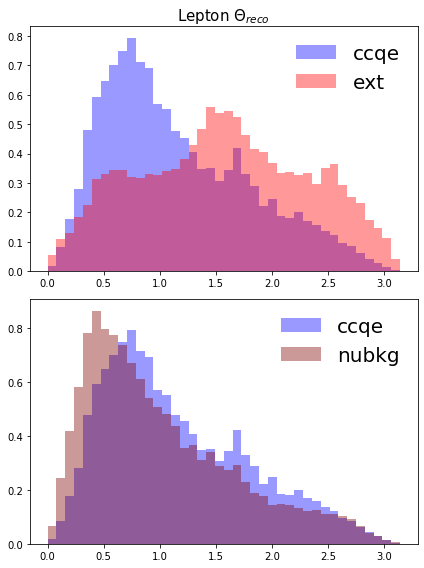

In [74]:
vartest = 'Lepton_ThetaReco'
varname = r'Lepton $\Theta_{reco}$'
myrange = (0,np.pi)
nbins = 40
yscale = 2e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 20007.0
MC:  19848.862884986516


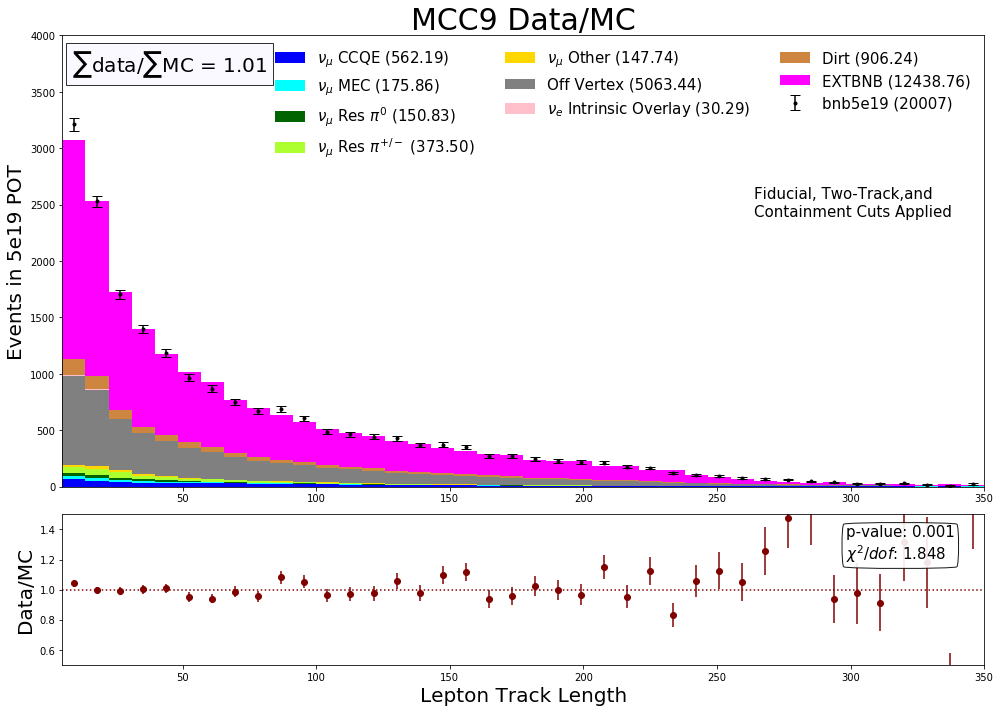

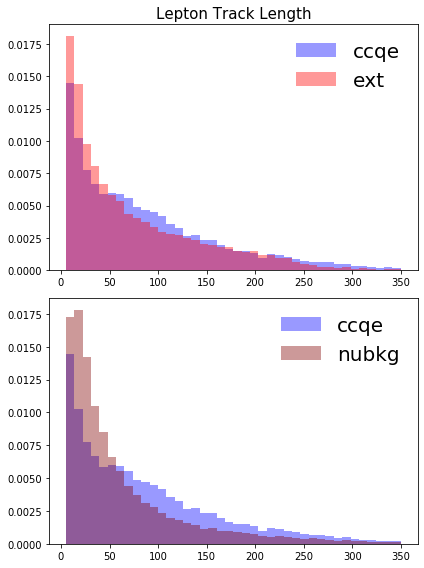

In [99]:
vartest = 'Lepton_TrackLength'
varname = 'Lepton Track Length'
myrange = (5,350)
nbins = 40
yscale = 4e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 20280.0
MC:  20104.23916217785


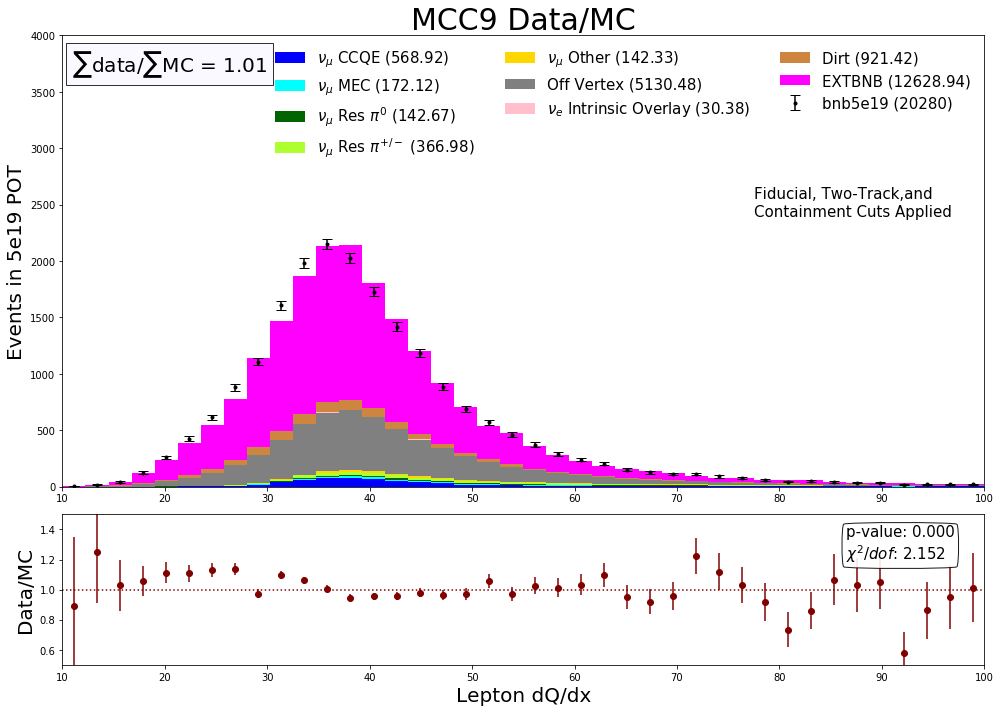

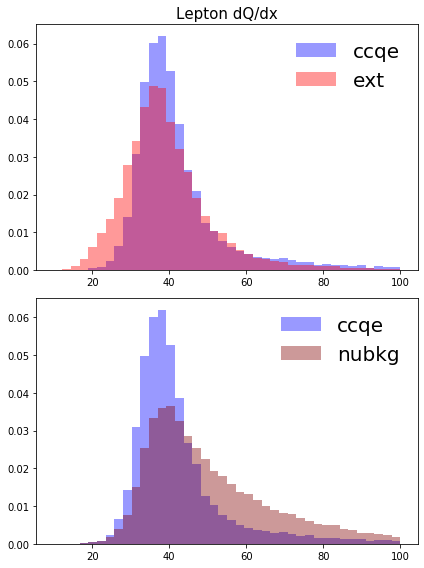

In [78]:
vartest = 'Lepton_dQdx'
varname = 'Lepton dQ/dx'
myrange = (10,100)
nbins = 40
yscale = 4e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 20403.0
MC:  20250.424170192753


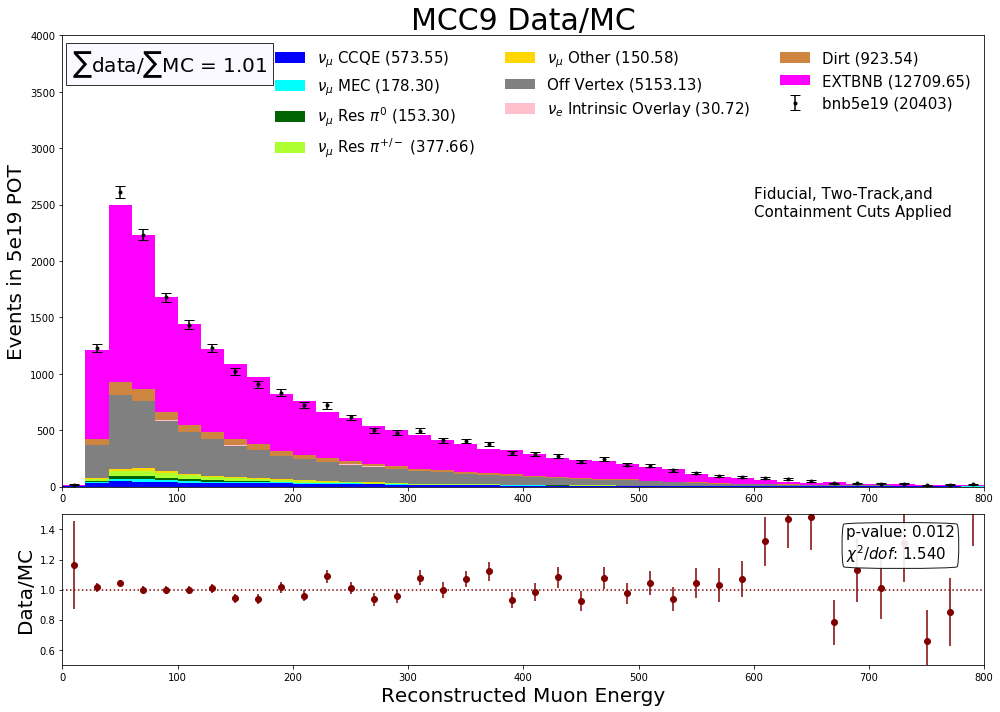

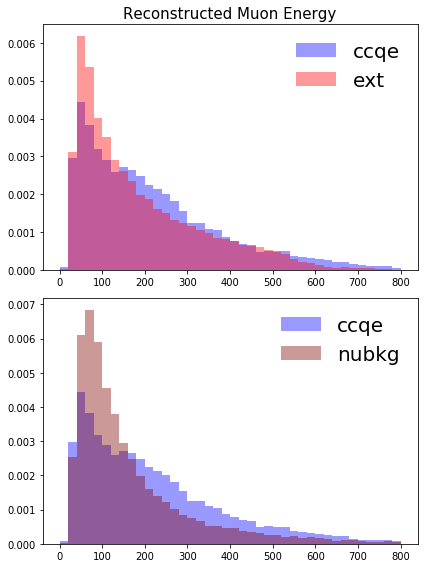

In [79]:
vartest = 'Muon_Edep'
varname = 'Reconstructed Muon Energy'
myrange = (0,800)
nbins = 40
yscale = 4e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 18533.0
MC:  18381.537380461545


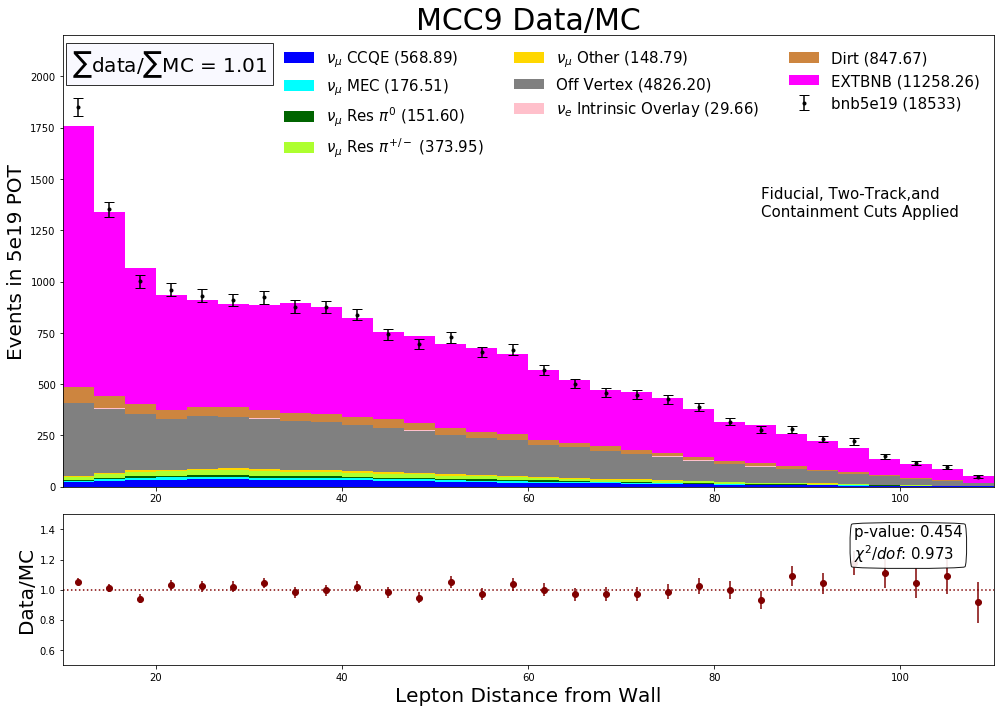

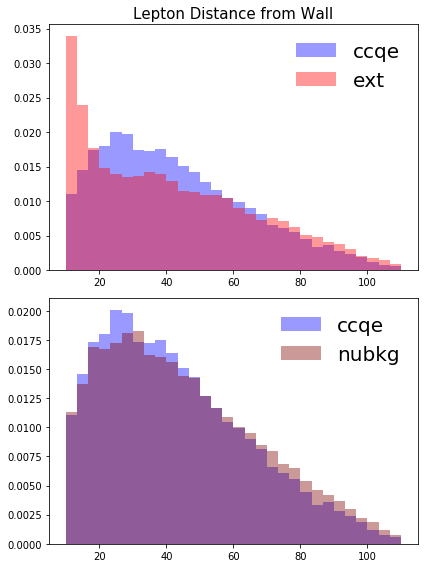

In [82]:
vartest = 'Lepton_EdgeDist'
varname = 'Lepton Distance from Wall'
myrange = (10,110)
nbins = 30
yscale = 2.2e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 20503.0
MC:  20329.002380235812


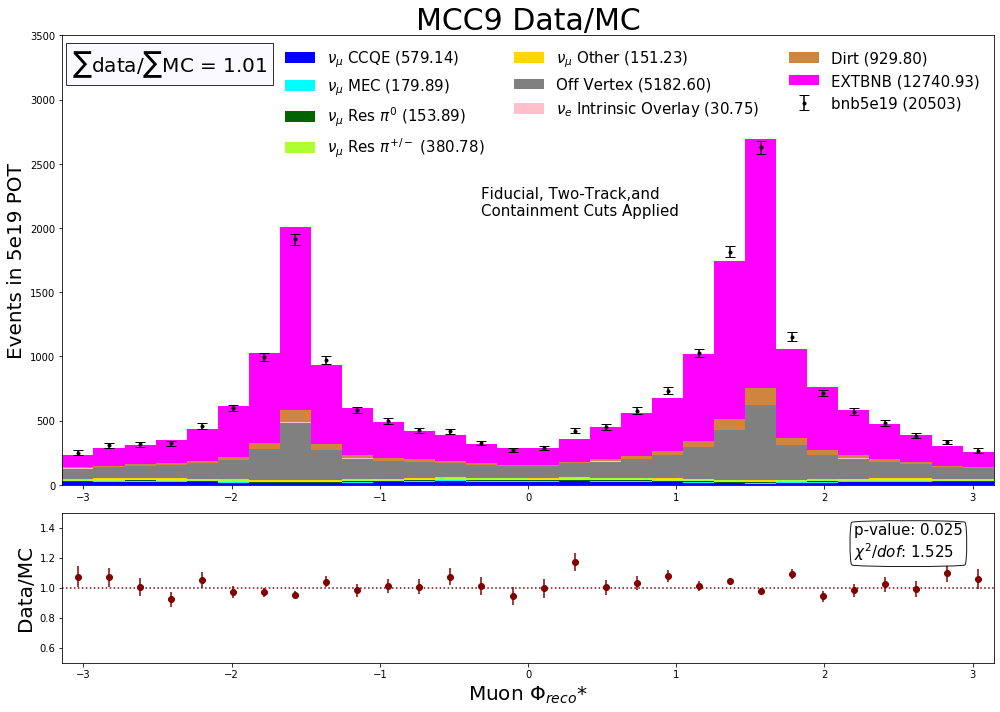

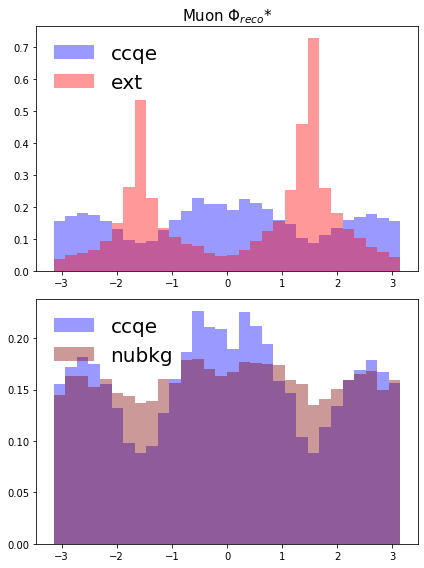

In [85]:
vartest = 'Muon_PhiRecoB_1m1p'
varname = r'Muon $\Phi_{reco}$*'
myrange = (-np.pi,np.pi)
nbins = 30
yscale = 3.5e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.45,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 20503.0
MC:  20329.002380235775


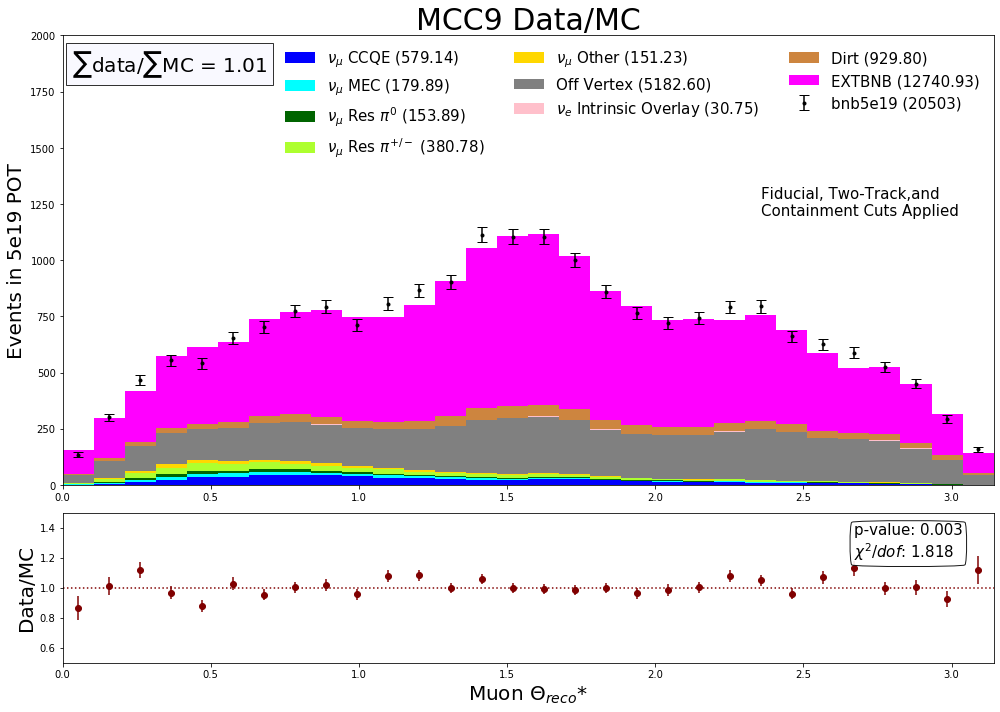

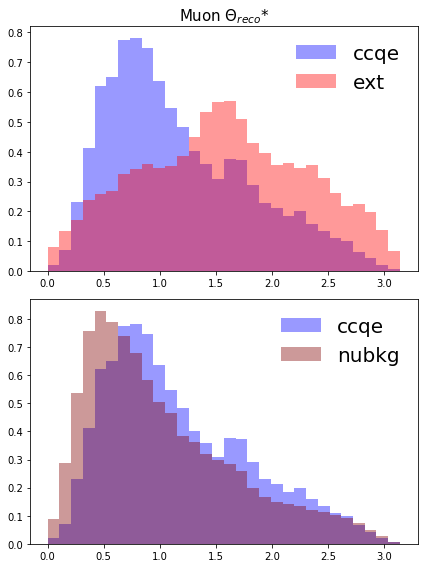

In [86]:
vartest = 'Muon_ThetaRecoB_1m1p'
varname = r'Muon $\Theta_{reco}$*'
myrange = (0,np.pi)
nbins = 30
yscale = 2e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 20111.0
MC:  19897.614828881648


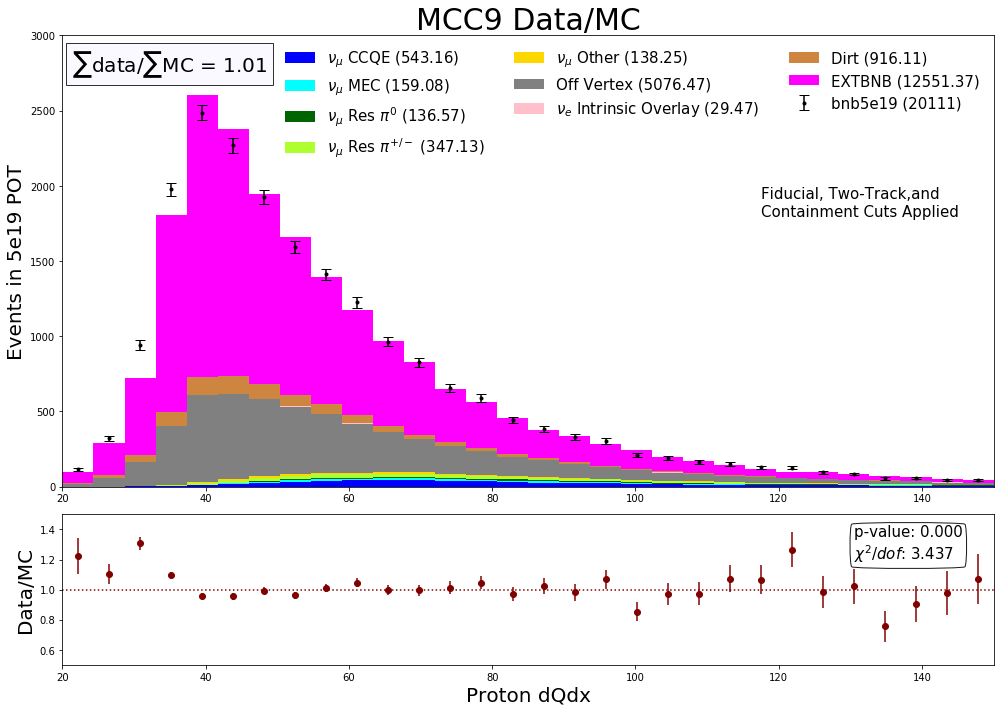

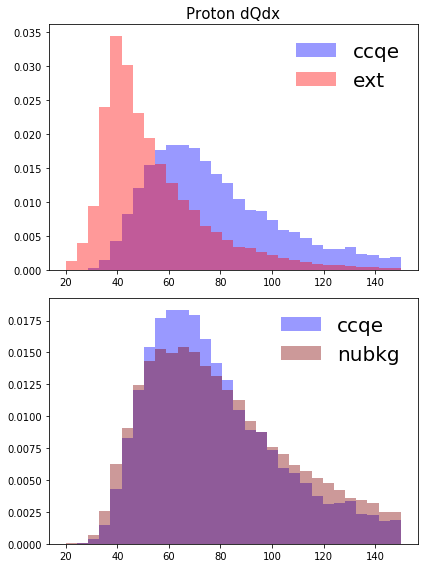

In [88]:
vartest = 'Proton_dQdx'
varname = 'Proton dQdx'
myrange = (20,150)
nbins = 30
yscale = 3e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 20413.0
MC:  20260.962234669296


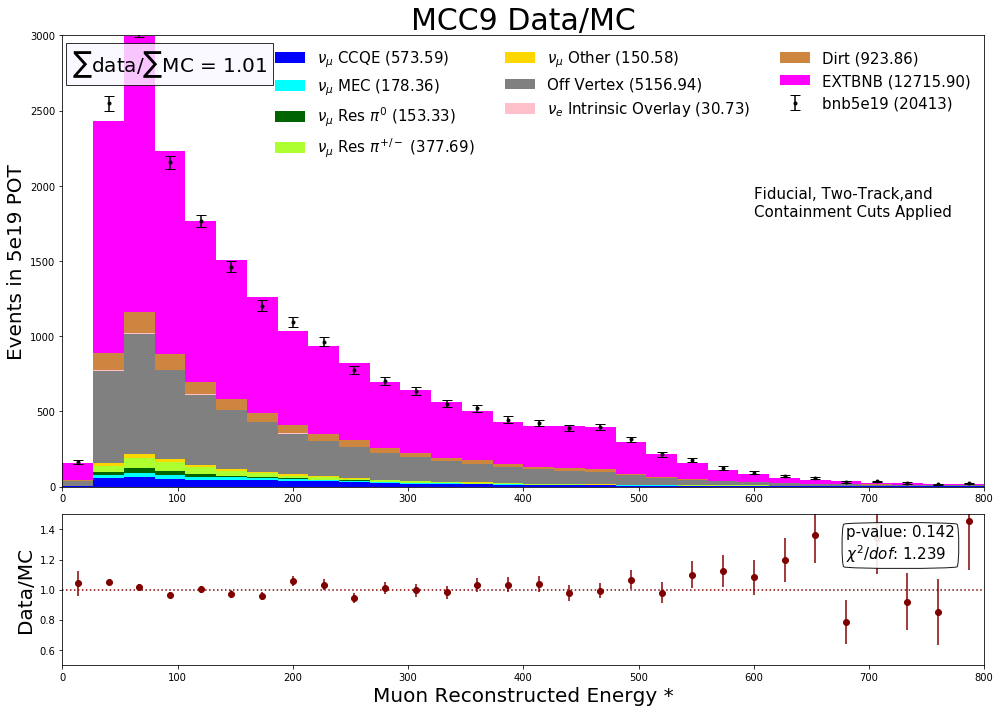

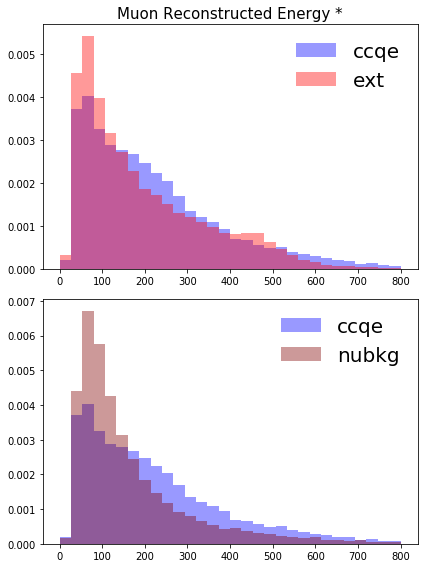

In [89]:
vartest = 'Muon_EdepB_1m1p'
varname = 'Muon Reconstructed Energy *'
myrange = (0,800)
nbins = 30
yscale = 3e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 20503.0
MC:  20329.002380235775


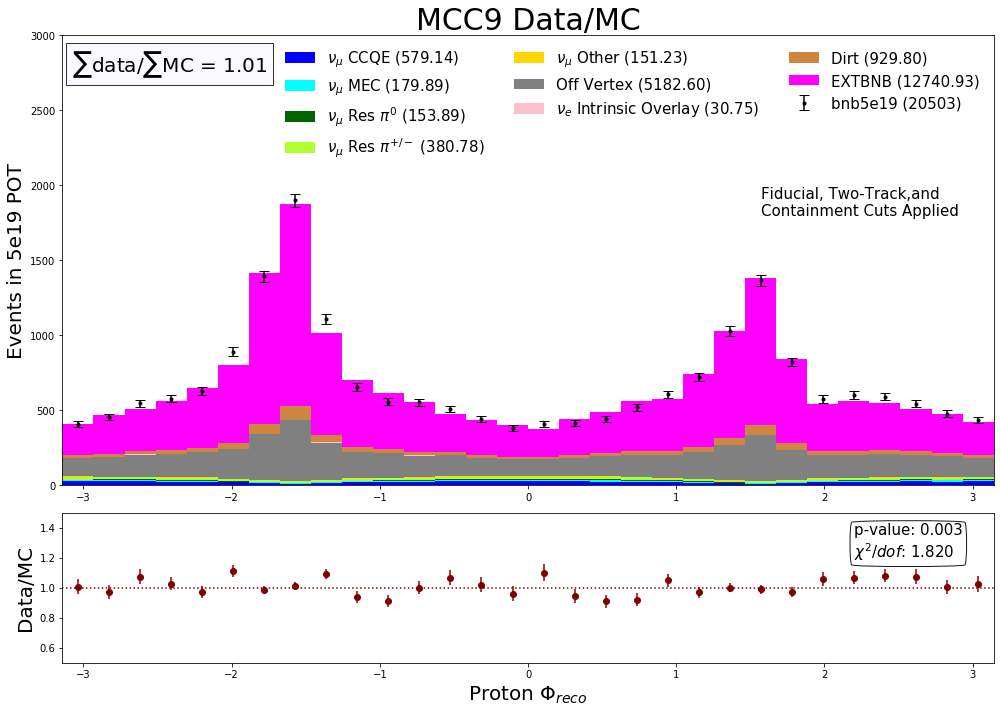

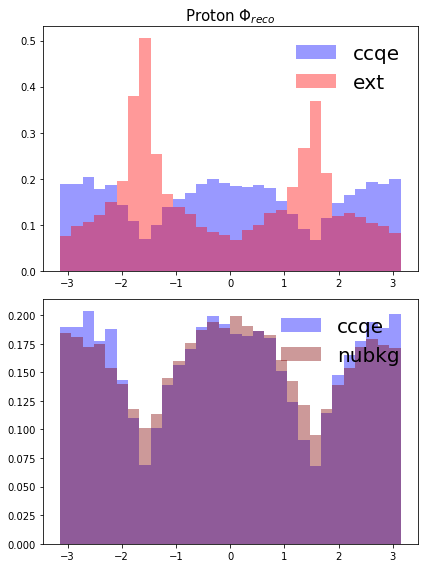

In [90]:
vartest = 'Proton_PhiReco'
varname = r'Proton $\Phi_{reco}$'
myrange = (-np.pi,np.pi)
nbins = 30
yscale = 3e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 20503.0
MC:  20329.002380235772


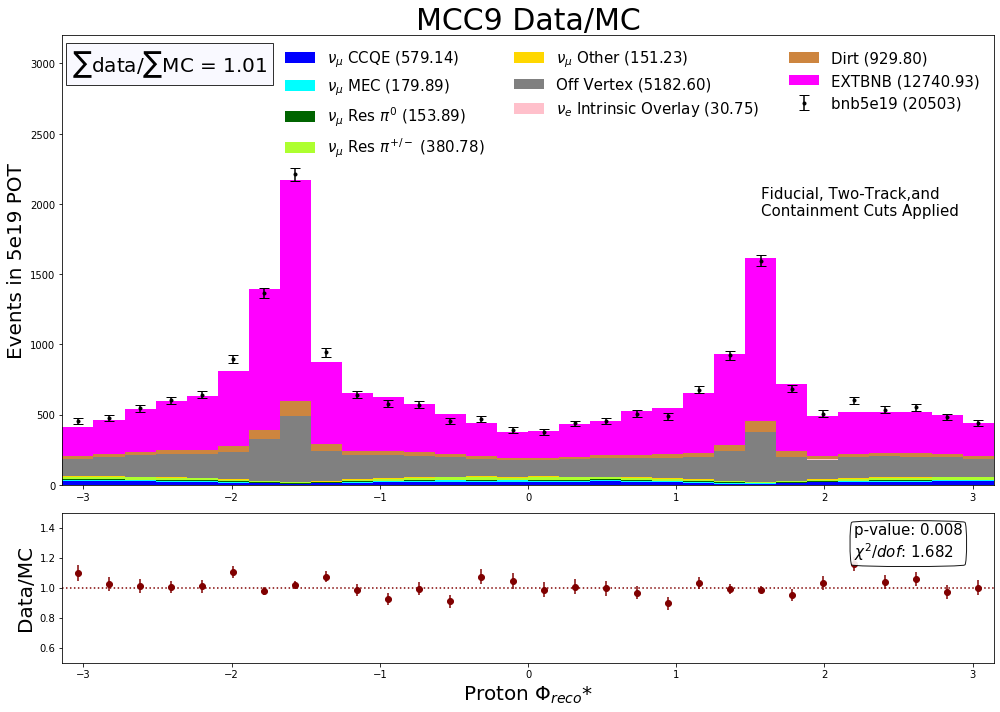

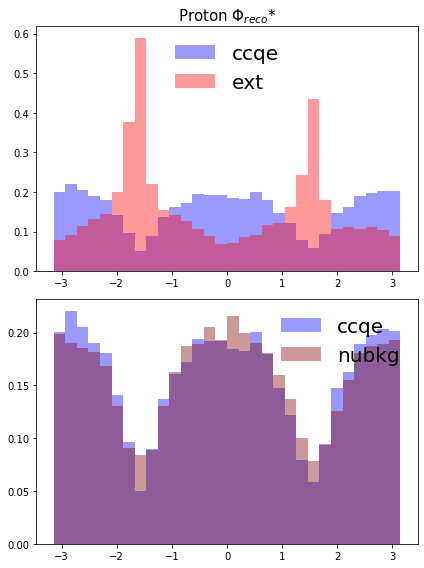

In [17]:
vartest = 'Proton_PhiRecoB_1m1p'
varname = r'Proton $\Phi_{reco}$*'
myrange = (-np.pi,np.pi)
nbins = 30
yscale = 3.2e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 20503.0
MC:  20329.002380235783


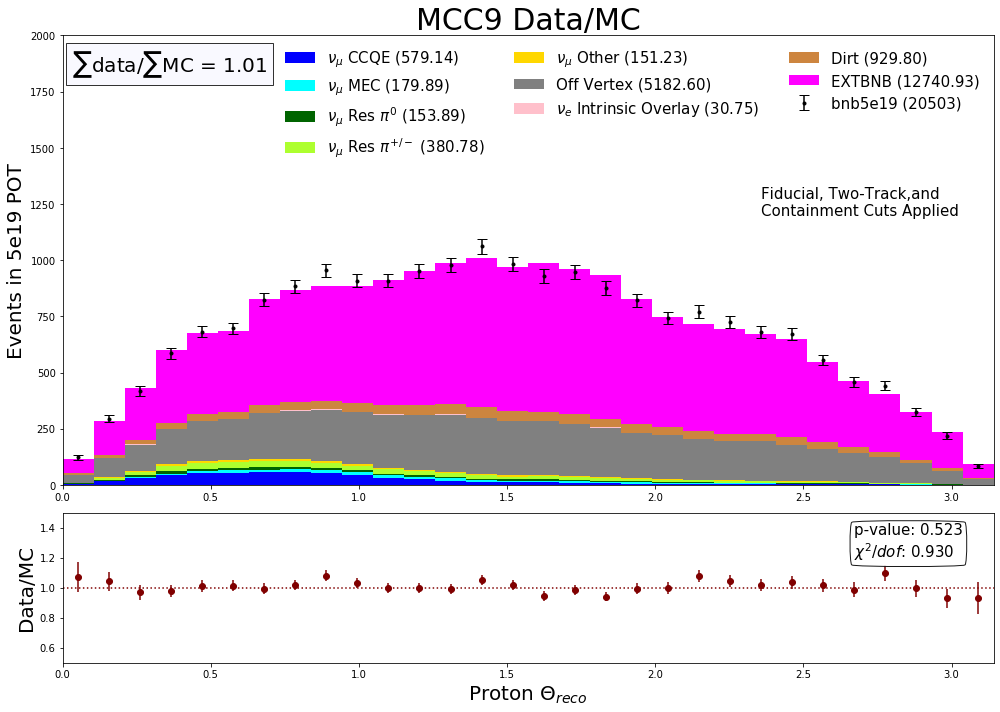

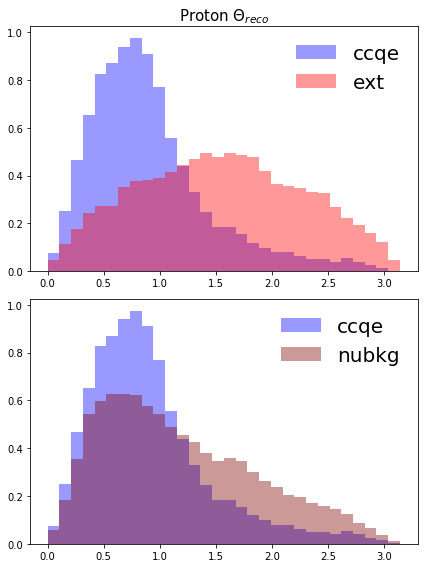

In [92]:
vartest = 'Proton_ThetaReco'
varname = r'Proton $\Theta_{reco}$'
myrange = (0,np.pi)
nbins = 30
yscale = 2e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 20503.0
MC:  20329.002380235772


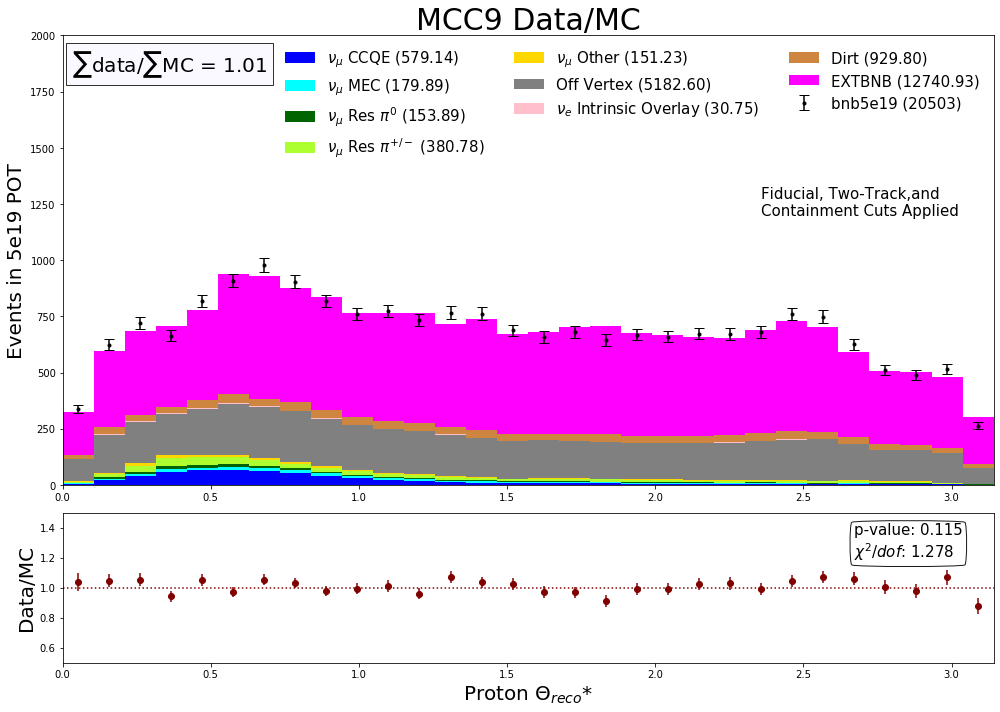

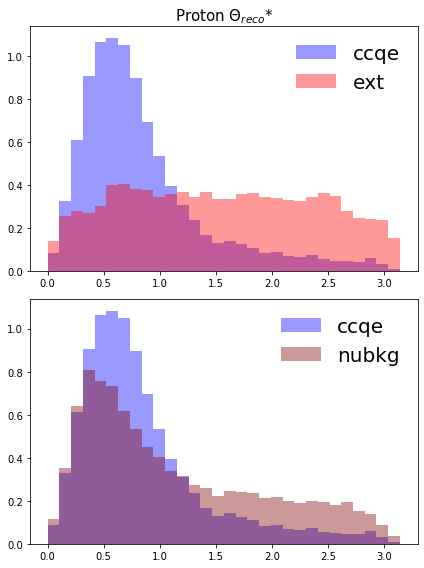

In [93]:
vartest = 'Proton_ThetaRecoB_1m1p'
varname = r'Proton $\Theta_{reco}$*'
myrange = (0,np.pi)
nbins = 30
yscale = 2e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 16697.0
MC:  16544.557422918533


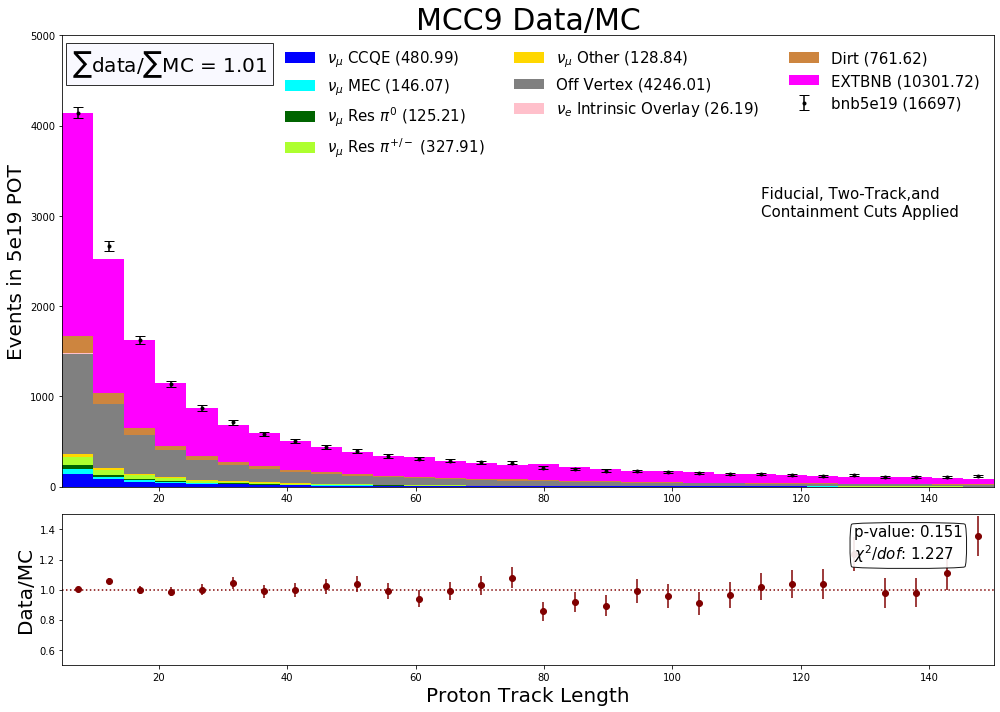

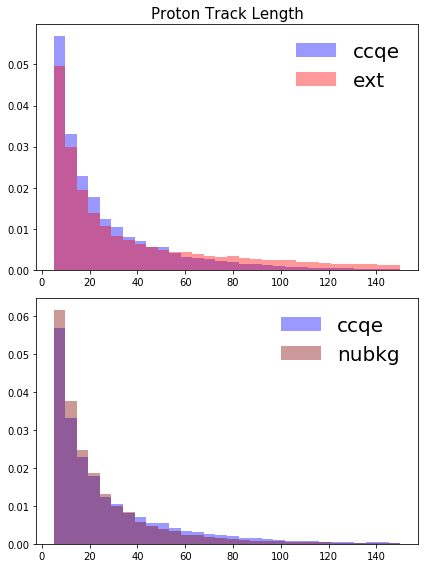

In [102]:
vartest = 'Proton_TrackLength'
varname = r'Proton Track Length'
myrange = (5,150)
nbins = 30
yscale = 5e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 20111.0
MC:  19897.614828881648


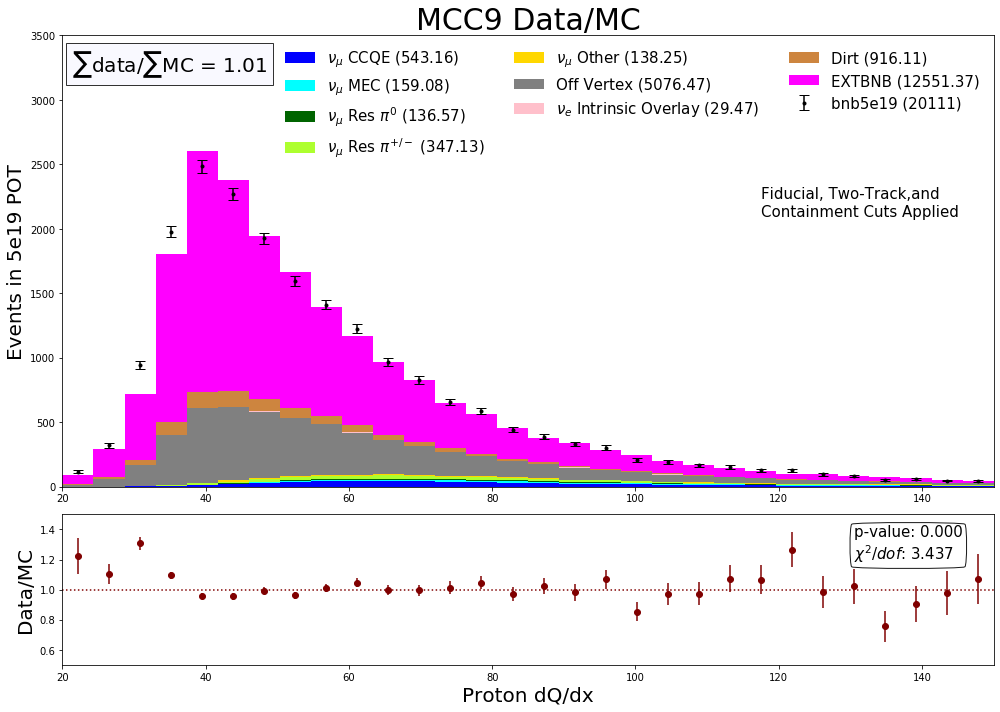

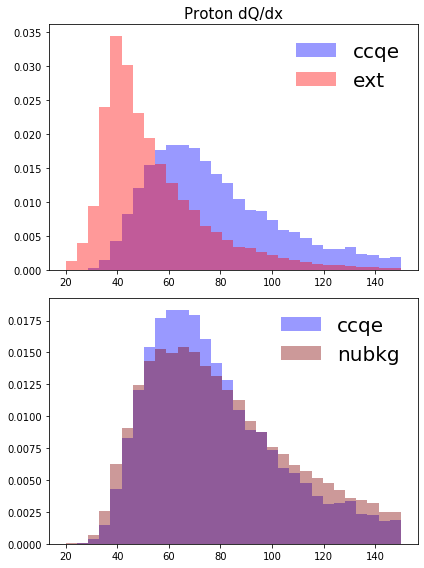

In [95]:
vartest = 'Proton_dQdx'
varname = 'Proton dQ/dx'
myrange = (20,150)
nbins = 30
yscale = 3.5e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 20442.0
MC:  20282.311175365165


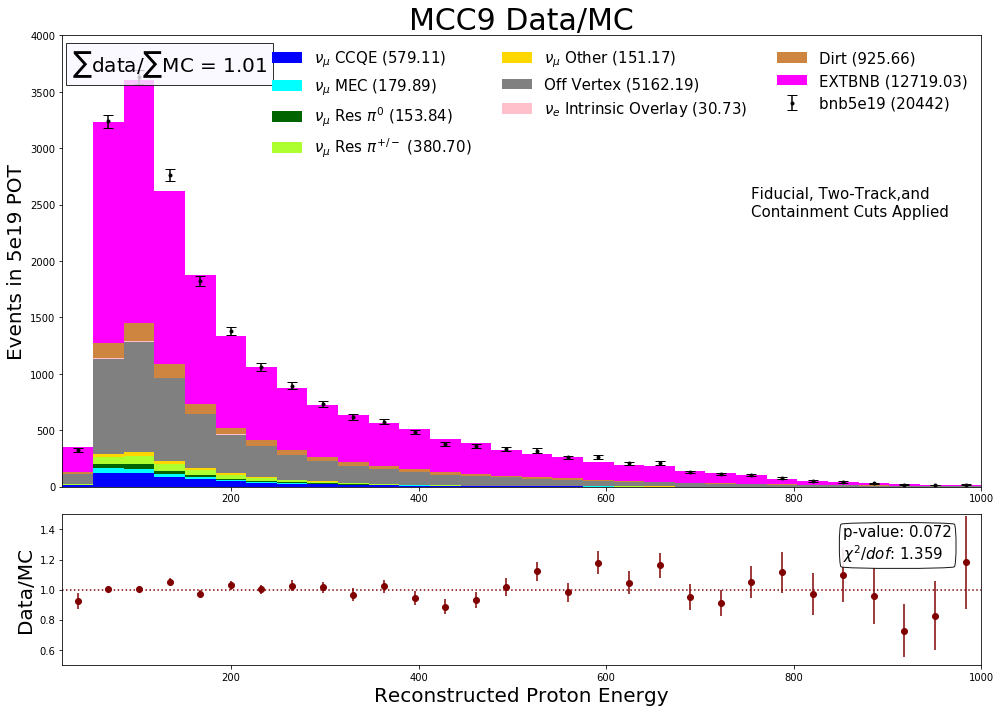

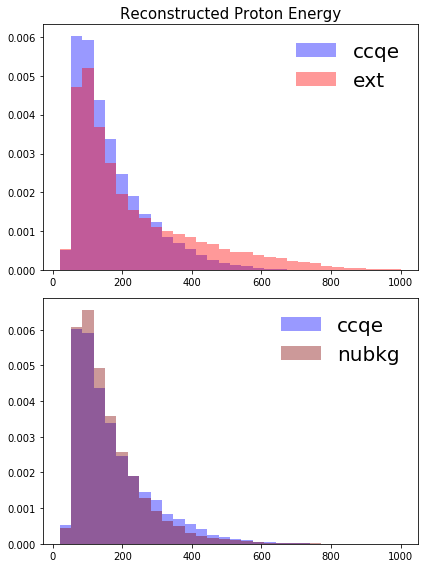

In [96]:
vartest = 'Proton_Edep'
varname = 'Reconstructed Proton Energy'
myrange = (20,1000)
nbins = 30
yscale = 4e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 20438.0
MC:  20261.261921930403


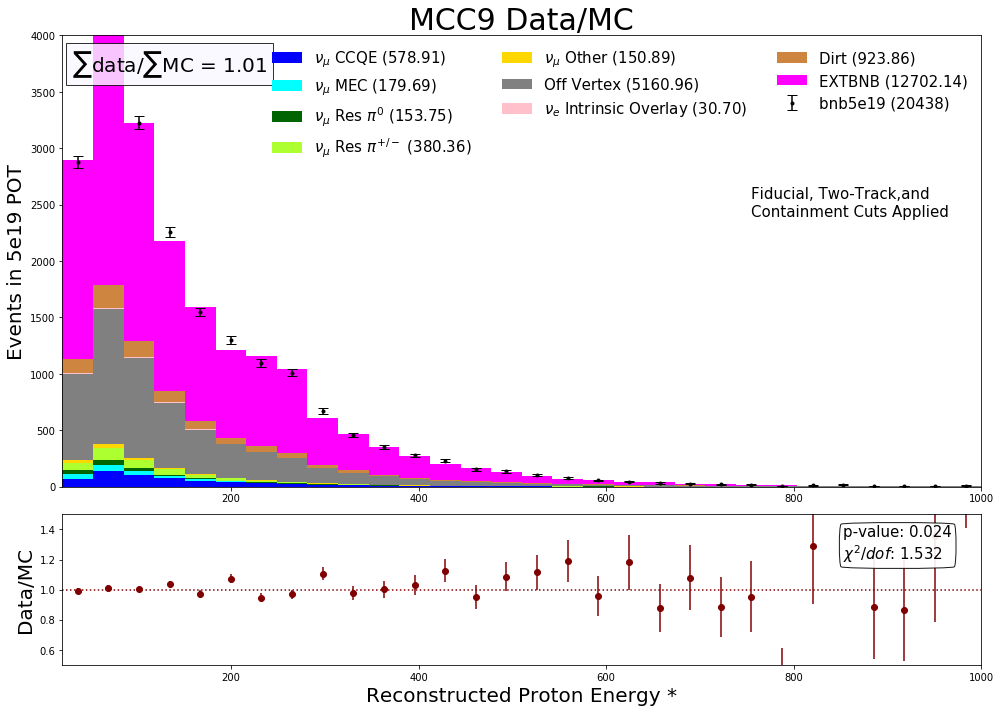

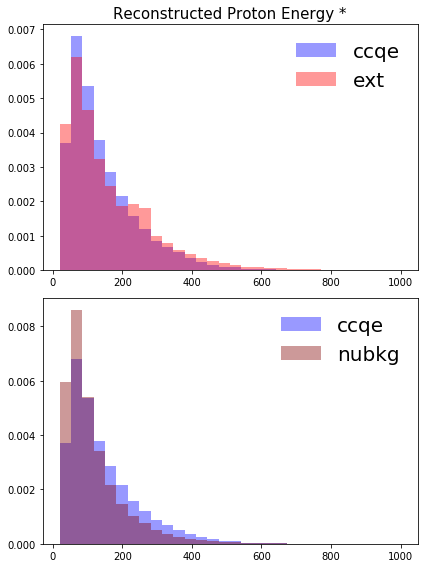

In [97]:
vartest = 'Proton_EdepB_1m1p'
varname = 'Reconstructed Proton Energy *'
myrange = (20,1000)
nbins = 30
yscale = 4e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 18131.0
MC:  18053.371656781157


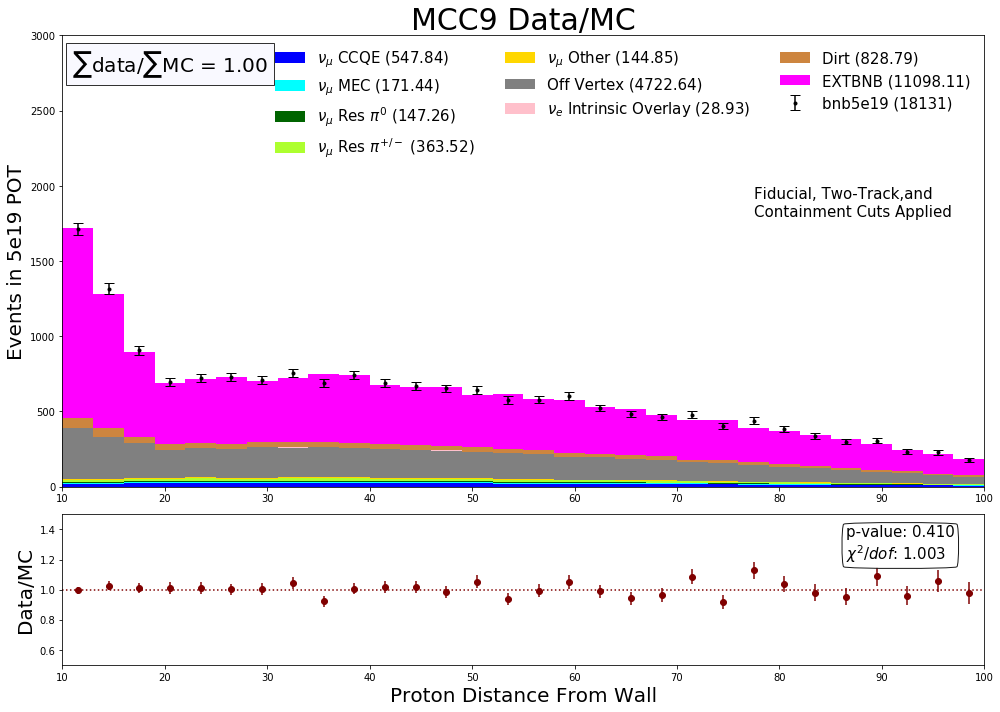

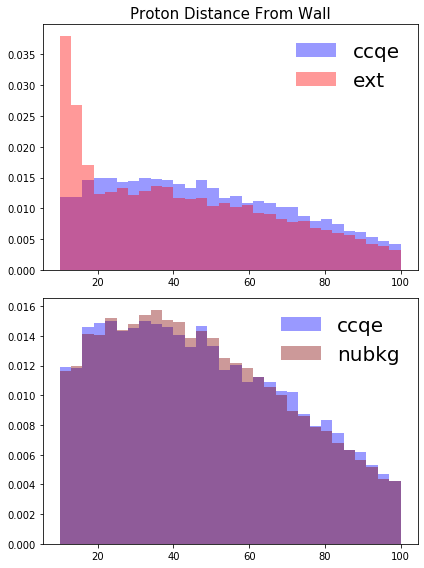

In [98]:
vartest = 'Proton_EdgeDist'
varname = 'Proton Distance From Wall'
myrange = (10,100)
nbins = 30
yscale = 3e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 20503.0
MC:  20329.00238023606


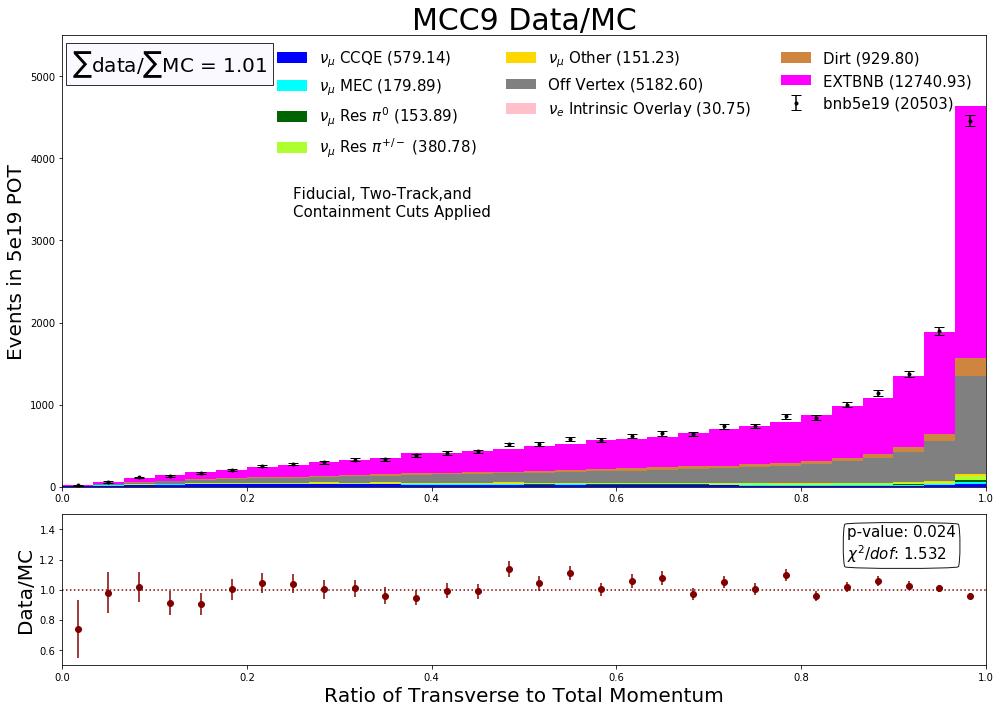

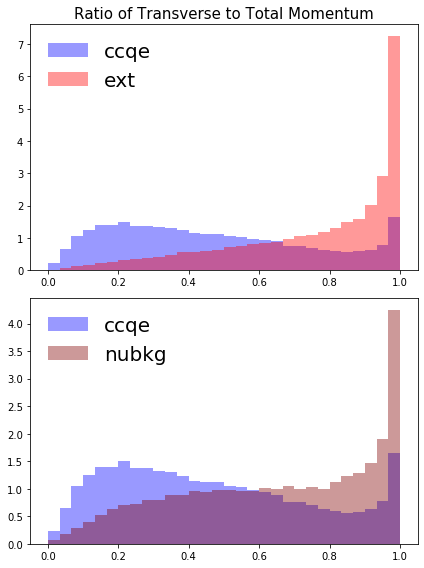

In [16]:
vartest = 'PTRat_1m1p'
varname = 'Ratio of Transverse to Total Momentum'
myrange = (0,1)
nbins = 30
yscale = 5.5e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.25,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

# Weight the bdts

In [11]:
df_signal = df_CCQE_numu_presel
df_extbkg = pd.concat([df_ext_presel,df_offvtx_numu_presel.query('run>=5119 and run<=5955')],sort=False)
df_nubkg = pd.concat([df_piplusminus_numu_presel,df_pizero_numu_presel,df_other_numu_presel,df_MEC_numu_presel],sort=False)

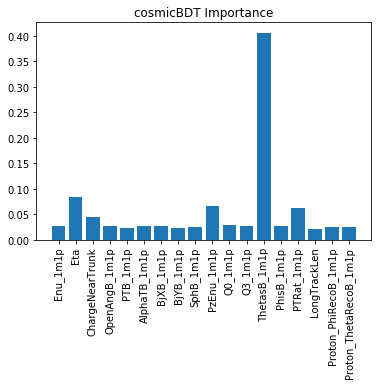

In [14]:
# Cosmic vs numu
jarretvars = ['SphB_1m1p','PzEnu_1m1p','BjXB_1m1p','BjYB_1m1p','Proton_ThetaRecoB_1m1p','Muon_ThetaRecoB_1m1p','Eta','OpenAngB_1m1p','PT_1m1p']

vars_vd = ['BjXB_1m1p','BjYB_1m1p','PT_1m1p','SphB_1m1p','Proton_ThetaRecoB_1m1p','Muon_ThetaRecoB_1m1p','Eta','Q0_1m1p','Q3_1m1p','ChargeNearTrunk','Phis','LongTrackLen','PTRat_1m1p','PzEnu_1m1p']
vars_vd2 = ['Enu_1m1p','Eta','ChargeNearTrunk','OpenAngB_1m1p','PTB_1m1p','AlphaTB_1m1p','BjXB_1m1p','BjYB_1m1p','SphB_1m1p','PzEnu_1m1p','Q0_1m1p','Q3_1m1p','ThetasB_1m1p','PhisB_1m1p','PTRat_1m1p','LongTrackLen','Proton_PhiRecoB_1m1p','Proton_ThetaRecoB_1m1p']


myvars = vars_vd2

X = df_signal[myvars].values.tolist()
Y_cos = df_extbkg[myvars].values.tolist()

#######################################################################################################
Xl = [1 for i in range(len(X))]
Yl = [0 for i in range(len(Y_cos))]

seed = 15
test_size = 0.5
x_train, x_test, y_train, y_test = train_test_split(asarray(X+Y_cos), asarray(Xl+Yl), test_size=test_size, random_state=seed)

eval_set = [(x_train, y_train), (x_test, y_test)]
cosmicBDT = XGBClassifier(max_depth=15,n_estimators=500)
cosmicBDT.fit(x_train, y_train)

y_checkV = cosmicBDT.predict(x_test) #
y_checkT = cosmicBDT.predict(x_train) #
#
predictionsV = [round(value) for value in y_checkV] #
predictionsT = [round(value) for value in y_checkT] #
accuracy_diff = (accuracy_score(y_test, predictionsV)-accuracy_score(y_train,predictionsT))*100. #

fig,ax = plt.subplots(figsize=(6,4))
ax.set_title('cosmicBDT Importance')
plt.bar(range(len(cosmicBDT.feature_importances_)), cosmicBDT.feature_importances_)
plt.xticks(range(len(cosmicBDT.feature_importances_)),myvars, rotation='vertical')
plt.show()

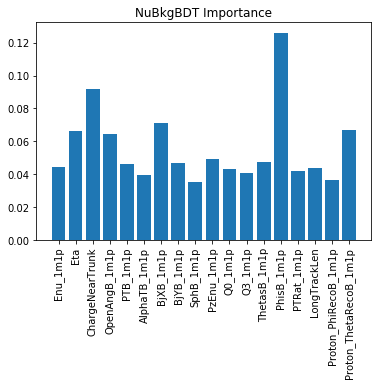

In [15]:
jarretvars = ['SphB_1m1p','PzEnu_1m1p','BjXB_1m1p','BjYB_1m1p','Proton_ThetaRecoB_1m1p','Muon_ThetaRecoB_1m1p','Eta','OpenAngB_1m1p','PT_1m1p']

vars_vd = ['BjXB_1m1p','BjYB_1m1p','PT_1m1p','SphB_1m1p','Proton_ThetaRecoB_1m1p','Muon_ThetaRecoB_1m1p','Eta','Q0_1m1p','Q3_1m1p','ChargeNearTrunk','Phis','LongTrackLen','PTRat_1m1p','PzEnu_1m1p']
vars_vd2 = ['Enu_1m1p','Eta','ChargeNearTrunk','OpenAngB_1m1p','PTB_1m1p','AlphaTB_1m1p','BjXB_1m1p','BjYB_1m1p','SphB_1m1p','PzEnu_1m1p','Q0_1m1p','Q3_1m1p','ThetasB_1m1p','PhisB_1m1p','PTRat_1m1p','LongTrackLen','Proton_PhiRecoB_1m1p','Proton_ThetaRecoB_1m1p']

myvars = vars_vd2

X = df_signal[myvars].values.tolist()
Y_nubkg = df_nubkg[myvars].values.tolist()

#######################################################################################################
Xl = [1 for i in range(len(X))]
Yl = [0 for i in range(len(Y_nubkg))]

seed = 15
test_size = 0.5
x_train, x_test, y_train, y_test = train_test_split(asarray(X+Y_nubkg), asarray(Xl+Yl), test_size=test_size, random_state=seed)

eval_set = [(x_train, y_train), (x_test, y_test)]
nubkgBDT = XGBClassifier(max_depth=15,n_estimators=500)
nubkgBDT.fit(x_train, y_train)

y_checkV = nubkgBDT.predict(x_test) #
y_checkT = nubkgBDT.predict(x_train) #
#
predictionsV = [round(value) for value in y_checkV] #
predictionsT = [round(value) for value in y_checkT] #
accuracy_diff = (accuracy_score(y_test, predictionsV)-accuracy_score(y_train,predictionsT))*100. #

fig,ax = plt.subplots(figsize=(6,4))
ax.set_title('NuBkgBDT Importance')
plt.bar(range(len(nubkgBDT.feature_importances_)), nubkgBDT.feature_importances_)
plt.xticks(range(len(nubkgBDT.feature_importances_)),myvars, rotation='vertical')
plt.show()

In [16]:
bdts = [cosmicBDT,nubkgBDT]
pickle.dump(bdts,open( "../1mu1pSelection/bdtweights_1mu1p_sparsenet_vd2.pickle", "wb" ))

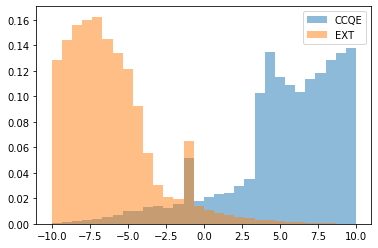

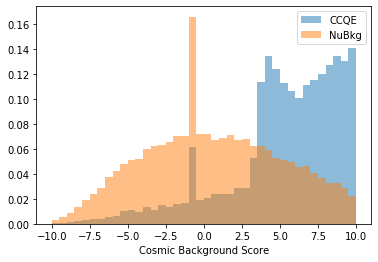

In [17]:
fig,ax = plt.subplots(figsize=(6,4))
bdt_score_ccqe = cosmicBDT.predict(X ,output_margin=True)
bdt_score_ext = cosmicBDT.predict(Y_cos,output_margin=True)

_ = plt.hist(bdt_score_ccqe,30,(-10,10),alpha = .5,density=1,label='CCQE')
_ = plt.hist(bdt_score_ext,30,(-10,10),alpha = .5,density=1,label='EXT')

plt.legend()

fig,ax = plt.subplots(figsize=(6,4))
bdt_score_nubkg = cosmicBDT.predict(Y_nubkg,output_margin=True)

_ = plt.hist(bdt_score_ccqe,40,(-10,10),alpha = .5,density=1,label='CCQE')
_ = plt.hist(bdt_score_nubkg,40,(-10,10),alpha = .5,density=1,label='NuBkg')
ax.set_xlabel('Cosmic Background Score')

plt.legend()

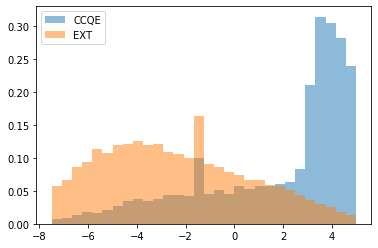

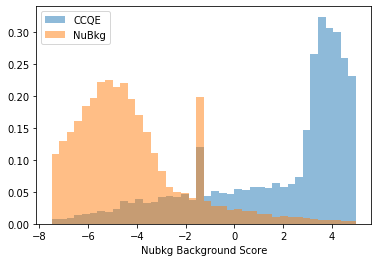

In [18]:
fig,ax = plt.subplots(figsize=(6,4))
bdt_score_ccqe = nubkgBDT.predict(X ,output_margin=True)
bdt_score_ext = nubkgBDT.predict(Y_cos,output_margin=True)

_ = plt.hist(bdt_score_ccqe,30,(-7.5,5),alpha = .5,density=1,label='CCQE')
_ = plt.hist(bdt_score_ext,30,(-7.5,5),alpha = .5,density=1,label='EXT')

plt.legend()

fig,ax = plt.subplots(figsize=(6,4))
bdt_score_nubkg = nubkgBDT.predict(Y_nubkg,output_margin=True)

_ = plt.hist(bdt_score_ccqe,40,(-7.5,5),alpha = .5,density=1,label='CCQE')
_ = plt.hist(bdt_score_nubkg,40,(-7.5,5),alpha = .5,density=1,label='NuBkg')
ax.set_xlabel('Nubkg Background Score')

plt.legend()